# DeckDetect

Este proyecto tiene como objetivo detectar y reconocer automáticamente cartas de la baraja de póker a partir de una imagen tomada con una cámara o cargada desde un archivo. El sistema identifica cada carta visible en la imagen, extrae su contenido y determina su número (valor) y su palo (símbolo).

## Objetivos principales:
- Detectar todas las cartas visibles en una imagen.
- Corregir la perspectiva para obtener una vista frontal de cada carta.
- Ajustar la orientación para que el número y el símbolo estén correctamente posicionados.
- Extraer las regiones correspondientes al número y al palo.
- Comparar dichas regiones con plantillas de referencia.
- Identificar y clasificar cada carta según su valor y su palo.

## Baraja utilizada:
Se utiliza la baraja estándar de póker:

- 13 valores (ranks): Ace, Two, Three, ..., Ten, Jack, Queen, King.
- 4 palos (suits): Clubs, Diamonds, Hearts, Spades.

## Flujo de procesamiento:
1. Preprocesamiento de imagen: conversión a escala de grises, detección de bordes y dilatación.
1. Detección de cartas: identificación de contornos con forma cuadrilátera.
1. Transformación de perspectiva: recorte alineado de cada carta.
1. Corrección de orientación: rotación para asegurar que el número esté arriba a la izquierda.
1. Extracción de número y símbolo: recorte de la esquina superior izquierda.
1. Comparación con plantillas: búsqueda del número y símbolo más parecidos.
1. Resultado final: identificación completa de la carta (por ejemplo, "King of Hearts").

## 1. Preparación del entorno
Importamos las librerías necesarias: OpenCV para procesamiento de imágenes, NumPy para operaciones matemáticas, Matplotlib para visualizar, y glob/os para gestionar archivos.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

## 2. Preprocesamiento de las cartas
Esta función convierte una imagen a escala de grises, la suaviza, detecta bordes con Canny, y luego los refuerza con dilatación.

In [2]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 42, 89)
    kernel = np.ones((2, 2))
    dilated = cv2.dilate(canny, kernel=kernel, iterations=2)
    return dilated

Aqui tenemos un pequeño ejemplo para ver su funcionamiento:

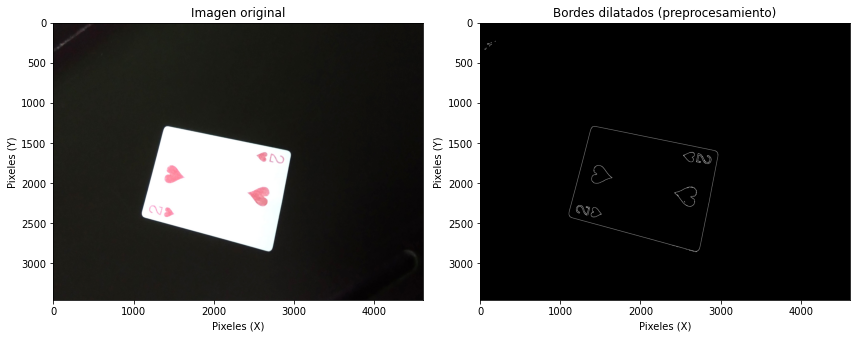

In [3]:
img = cv2.imread("Fotos/Imagenes/2H27.jpg")
edges = preprocess_image(img)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Imagen original")
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(edges, cmap='gray')
axs[1].set_title("Bordes dilatados (preprocesamiento)")
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()

## 3. Ordenar esquinas del contorno

Cuando detectamos una carta, sus 4 esquinas pueden estar en cualquier orden. Esta función reorganiza esos puntos para que siempre estén en el orden correcto:

1. Top-left
1. Top-right
1. Bottom-right
1. Bottom-left

Esto es esencial para poder aplicar correctamente una transformación de perspectiva más adelante. También incluye una verificación extra por si se detectan coordenadas duplicadas (poco común, pero posible).

In [4]:
def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    tl_index = np.argmin(s)
    br_index = np.argmax(s)
    tr_index = np.argmin(diff)
    bl_index = np.argmax(diff)

    # Asegurar que todos los índices sean distintos
    used = {tl_index, br_index, tr_index, bl_index}
    if len(used) < 4:
        # Si hay repetidos, hacer una asignación más segura
        # Ordenar por Y (de arriba a abajo), luego X
        sorted_pts = sorted(pts, key=lambda p: (p[1], p[0]))
        top_two = sorted(sorted_pts[:2], key=lambda p: p[0])  # izq, der
        bottom_two = sorted(sorted_pts[2:], key=lambda p: p[0])  # izq, der
        rect[0], rect[1] = top_two
        rect[3], rect[2] = bottom_two
    else:
        rect[0] = pts[tl_index]
        rect[2] = pts[br_index]
        rect[1] = pts[tr_index]
        rect[3] = pts[bl_index]

    return rect

## 4. Transformación de perspectiva (warp)
Una vez tenemos los 4 puntos de una carta en el orden correcto, esta función "endereza" la carta como si la viéramos desde arriba.

Pasos que realiza:

1. Calcula las dimensiones reales de la carta usando distancias entre esquinas.
1. Define una nueva cuadrícula rectangular para la carta ya rectificada.
1. Aplica una transformación de perspectiva para que la carta aparezca derecha y recortada.

Resultado: una imagen limpia, alineada y lista para analizar su contenido (número y palo).

In [5]:
def warp_card(image, contour):
    contour = contour.reshape(4, 2)
    ordered = sort_corners(contour)
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

## 5. Detección de contornos de cartas

Una vez tenemos la imagen procesada, buscamos contornos que representen cartas.

- Usamos cv2.findContours con RETR_TREE para obtener la jerarquía de contornos (útil para descartar los internos).
- Filtramos contornos externos y con un área mínima para evitar falsos positivos.
- Aplicamos approxPolyDP sobre el convex hull del contorno para obtener una forma más regular.
- Si el contorno tiene 4 lados, lo consideramos una carta. Si no, usamos un método alternativo (minAreaRect) para obtener una caja rectangular aproximada.

Resultado: una lista de contornos que representan cartas detectadas.

In [6]:
def find_card_contours(edges):
    # Usamos RETR_TREE para tener jerarquía y descartar contornos internos
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    card_contours = []

    if hierarchy is None:
        return card_contours

    hierarchy = hierarchy[0]
    
    for i, cnt in enumerate(contours):
        # Solo consideramos contornos sin padre (externos)
        if hierarchy[i][3] != -1:
            continue

        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        # Suavizamos la forma con convex hull
        hull = cv2.convexHull(cnt)
        perimeter = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.015 * perimeter, closed=True)

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # Si el hull+approx aún falla, usar minAreaRect como fallback
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours

Aqui tenemos un ejemplo de la función para encontrar los contornos de una carta:

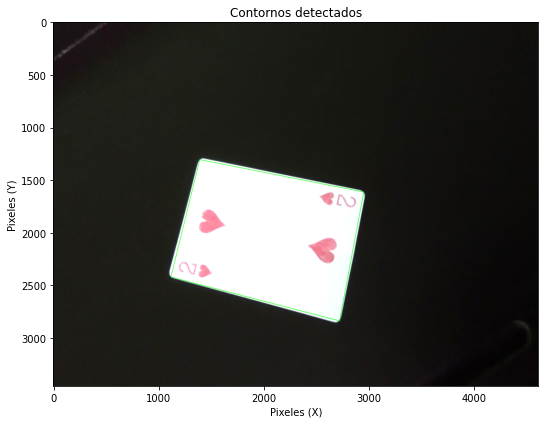

In [7]:
edges = preprocess_image(img)
contornos = find_card_contours(edges)

# Dibujar los contornos detectados sobre una copia de la imagen original
img_contornos = img.copy()
cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 3)

# Mostrar resultado
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.title("Contornos detectados")
plt.xlabel("Pixeles (X)")
plt.ylabel("Pixeles (Y)")
plt.tight_layout()
plt.show()

## 6. Corrección de orientación de la carta
Esta función verifica si la carta se encuentra en la orientación vertical adecuada, es decir, que su alto sea mayor que su ancho. Esto es útil como una primera etapa de corrección, especialmente después de recortar la carta desde la imagen original.

Para ello, se evalúan las dimensiones de la imagen y, si es necesario, se rota 90° en sentido horario para que la carta quede en posición vertical.


¿Cómo lo hace?

- Se obtienen las dimensiones de la imagen (`alto` y `ancho`).
- Si el **ancho** es mayor que el **alto**, se asume que la carta está girada.
- Se realiza una rotación de **90° en sentido horario** (`cv2.ROTATE_90_CLOCKWISE`).
- Si el parámetro `debug=True`, se muestran mensajes informativos del proceso.


In [8]:
def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]

    if debug:
        print(f"Dimensiones - Alto: {h}, Ancho: {w}")

    # Si la imagen es más ancha que alta, rotamos 90°
    if w > h:
        if debug:
            print("Rotando la carta 90° en sentido horario")
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)

    return card_img

Ahora aqui veremos un ejemplo de la función correct_card_orientation, donde primero se buscan los contornos de la carta y luego se orienta la carta:

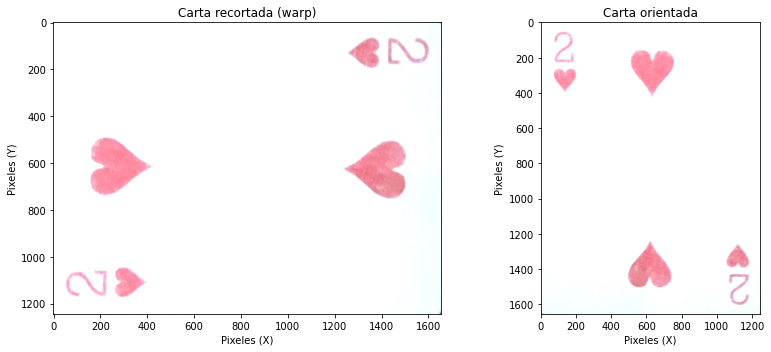

In [9]:
contornos = find_card_contours(preprocess_image(img))

if contornos:
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Carta recortada (warp)")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(oriented, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Carta orientada")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()

## 7. Binarización de una región
Esta función convierte una región (en escala de grises o en color) en una imagen binaria, donde los elementos relevantes (como números o símbolos) quedan en blanco sobre fondo negro.

Pasos que realiza:

1. Asegura que los parámetros `block_size` y blur_ksize sean impares, ya que así lo requiere OpenCV.
1. Convierte la región a escala de grises si aún no lo está.
1. Aplica CLAHE (opcional, pero activado por defecto) para mejorar el contraste local, útil cuando la imagen tiene iluminación desigual.
1. Suaviza la imagen con un desenfoque gaussiano para reducir el ruido.
1. Aplica un umbral adaptativo con inversión (`THRESH_BINARY_INV`), lo que resalta las zonas oscuras sobre fondo claro.

Este proceso mejora la segmentación de caracteres y símbolos para su posterior análisis.

In [10]:
def binarize_region(region, block_size=15, C=2, blur_ksize=5, use_clahe=True):
    # Asegura que el block_size y blur_ksize sean impares
    block_size = block_size if block_size % 2 == 1 else block_size + 1
    blur_ksize = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1
    
    # Conversión a escala de grises si es necesario
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region

    # Mejora de contraste local con CLAHE (opcional pero muy efectivo)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    # Suavizado con Gaussian Blur (reduce ruido antes del umbral)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Binarización adaptativa con inversión
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size, C
    )

    return binary

## 8. Suavizado morfológico
Esta función aplica operaciones morfológicas sobre una imagen binaria para mejorar su limpieza y legibilidad.

Pasos que realiza:

1. Cierre morfológico (`MORPH_CLOSE`): rellena pequeños huecos negros dentro de áreas blancas.
1. Apertura morfológica (`MORPH_OPEN`): elimina puntos blancos aislados que puedan considerarse ruido.

El resultado es una imagen binaria más limpia, ideal para una detección de contornos más precisa. Se utiliza comúnmente después de la binarización para mejorar la calidad de las regiones a analizar.

In [11]:
def morphological_smoothing(binary_img, kernel_size_open=(3, 3), kernel_size_close=(5, 5)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)

    # 1. Tapar huecos negros en zonas blancas
    closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # 2. Quitar puntitos blancos sueltos
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

    return opened

## 9. Extracción del número y símbolo de la carta

Esta función se encarga de identificar y extraer la región donde se encuentra el número (rango) y el símbolo (palo) de la carta, generalmente ubicados en la esquina superior izquierda.

Pasos que realiza:

1. Se recorta una región de interés (ROI) desde la esquina superior izquierda de la carta. Esta región cubre aproximadamente el 25% de la altura y el 18% del ancho de la imagen. Estos valores pueden ajustarse si es necesario.
1. Se convierte la región a escala de grises, se mejora su contraste y se binariza usando un umbral adaptativo.
1. Se aplica suavizado morfológico para limpiar la imagen.
1. Se detectan contornos externos y se seleccionan los dos más grandes, asumiendo que corresponden al número y al palo.
1. Se ordenan los contornos de arriba hacia abajo (por coordenada vertical), y cada uno se recorta y redimensiona:
1. El primer contorno se considera el número.
1. El segundo contorno se considera el palo.
1. Si se encuentra exactamente un número y un palo, ambos se devuelven como imágenes separadas. En caso contrario, se devuelve `None`.
1. Si `debug=True`, se muestran visualizaciones del ROI, la binarización y las regiones recortadas del número y símbolo para facilitar la depuración.

In [12]:
def extract_number_suit_region(card_img, debug=False):
    h, w = card_img.shape[:2]

    # 🔍 Recorte desde la esquina superior izquierda
    roi = card_img[0:int(h * 0.25), 0:int(w * 0.15)]  # zona donde aparece número y palo

    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("ROI (Esquina superior izquierda)")
        plt.axis("off")
        plt.show()

    # 🔎 Preprocesado y binarización
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    bin_roi = binarize_region(gray_roi, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)

    # 📏 Buscar contornos externos
    contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 🧹 FILTRAR: ignorar contornos muy pequeños (ruido)
    filtered_contours = [c for c in contours if cv2.contourArea(c) > 80]

    if debug:
        print(f"Contornos totales: {len(contours)} | Filtrados: {len(filtered_contours)}")
        drawn = roi.copy()
        cv2.drawContours(drawn, filtered_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Contornos Filtrados (Verde)")
        plt.axis("off")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(bin_roi, cmap="gray")
        plt.title("Binarización Final")
        plt.axis("off")
        plt.show()

    # 🧠 Elegimos los 2 contornos más grandes
    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:2]
    filtered_contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[1])  # orden por Y

    ranksuit = []
    _rank = None

    for i, cnt in enumerate(filtered_contours):
        x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
        x2, y2 = x + w_cnt, y + h_cnt
        crop = roi[y:y2, x:x2]

        if i == 0:  # Rank (número)
            crop = cv2.resize(crop, (70, 125), interpolation=cv2.INTER_AREA)
            _rank = crop
        else:  # Suit (palo)
            crop = cv2.resize(crop, (70, 100), interpolation=cv2.INTER_AREA)

            if debug and _rank is not None:
                r_vis = cv2.resize(_rank, (70, 100))
                s_vis = cv2.resize(crop, (70, 100))
                joined = np.concatenate((r_vis, s_vis), axis=1)
                joined = cv2.resize(joined, (250, 200))
                plt.imshow(cv2.cvtColor(joined, cv2.COLOR_BGR2RGB))
                plt.title("Número y Palo")
                plt.show()

        ranksuit.append(crop)

    if len(ranksuit) != 2:
        return None, None

    return ranksuit[0], ranksuit[1]

En el código de abajo podemos ver un ejemplo del funcionamiento de la función encargada de extraer el número y el palo de una carta:

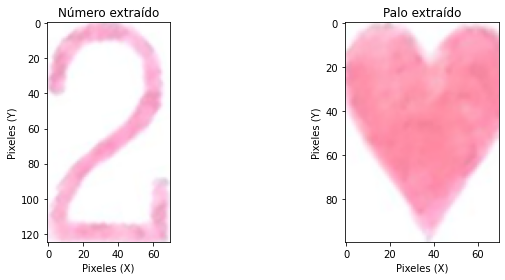

In [13]:
number_img, suit_img = extract_number_suit_region(oriented)

if number_img is not None and suit_img is not None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(cv2.cvtColor(number_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Número extraído")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(suit_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Palo extraído")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()

## 10. Utilidades para preparar imágenes y plantillas

Estas funciones se encargan de normalizar, binarizar o redimensionar imágenes para que puedan ser comparadas correctamente con las plantillas.

- `resize_for_template(img, template_shape)`: redimensiona una imagen para que tenga el mismo tamaño que una plantilla.
- `normalize_for_template(img)`: aplica desenfoque y normalización de intensidad, útil en ciertos casos para estandarizar imágenes antes de comparar.
- `binarize_template(template)`: convierte una plantilla en imagen binaria mediante umbralado fijo. Asume que los elementos están sobre fondo blanco y no se invierte el resultado.

In [14]:
def resize_for_template(img, template_shape):
    return cv2.resize(img, (template_shape[1], template_shape[0]), interpolation=cv2.INTER_AREA)

def normalize_for_template(img):
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    norm = cv2.normalize(blur.astype('float32'), None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype('uint8')

def binarize_template(template):
    gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) if len(template.shape) == 3 else template
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # SIN _INV
    return binary

    return binary

## 11. Verificación de contenido en una región

La función region_has_rank_or_suit se utiliza para comprobar si una región (por ejemplo, una esquina de la carta) contiene información relevante como un número o un símbolo.

Para ello:

- Convierte la región a escala de grises.
- Calcula la desviación estándar de la intensidad (para medir variación).
- Cuenta la cantidad de píxeles "oscuros".

Devuelve `True` si la variación y la cantidad de píxeles oscuros superan ciertos umbrales, lo que indica que probablemente hay contenido gráfico en la región.

In [15]:
def region_has_rank_or_suit(roi, std_thresh=15, dark_thresh=80, min_dark_pixels=250, debug=False):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    std = np.std(gray)
    dark_pixels = np.sum(gray < dark_thresh)

    if debug:
        print(f"STD: {std:.2f}, Dark Pixels: {dark_pixels}")

    return std > std_thresh and dark_pixels > min_dark_pixels

## 12. Carga de plantillas de números y palos

La función `load_templates` carga todas las plantillas de números y símbolos desde la carpeta `Fotos/Plantillas`, dentro de esta carpeta tenemos dos plantillas distintas que son usadas en las funciones correspondientes.

- Busca todos los archivos `.jpg` cuyo nombre comience con el nombre del número o palo (`Ace`, `Two`, `Clubs`, etc.).
- Cada plantilla se carga en escala de grises y se almacena en un diccionario con su nombre como clave.

Devuelve dos diccionarios:

- `number_templates`: para comparar números.
- `suit_templates`: para comparar palos.

In [16]:
def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']

    number_templates = {}
    suit_templates = {}

    for n in numbers:
        pattern = f'Fotos/Plantillas/{n}*.jpg'
        matches = glob.glob(pattern)
        number_templates[n] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    for s in suits:
        pattern = f'Fotos/Plantillas/{s}*.jpg'
        matches = glob.glob(pattern)
        suit_templates[s] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    return number_templates, suit_templates

## 13. Comparación de una región con plantillas

La función `match_template` compara una región de una carta (como el número o el símbolo) con un conjunto de plantillas precargadas.

Pasos que realiza:

1. Binariza y suaviza la región objetivo.
1. Para cada plantilla del conjunto:
- Se binariza.
- Se redimensiona la región objetivo al tamaño de la plantilla.
- Se calcula una correlación normalizada (`cv2.matchTemplate`) para comparar similitud.
3. Se selecciona la plantilla con mayor puntuación como resultado.

Opcionalmente, se pueden mostrar las imágenes comparadas si `debug=True`.

In [17]:
def match_template(region, templates, debug=False):
    # binary = binarize_region(region)

    bin_roi = binarize_region(region, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)
    binary = morphological_smoothing(bin_roi)
    
    best_name, best_score = "Desconocido", -1

    for name, template_list in templates.items():
        for template in template_list:
            if template is None:
                continue

            templ_bin = binarize_template(template)
            # templ_bin = normalize_for_template(templ_bin)

            resized = cv2.resize(binary, (templ_bin.shape[1], templ_bin.shape[0]), interpolation=cv2.INTER_AREA)

            if debug:
                # Mostrar REGION (izquierda)
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(binary, cmap='gray')
                plt.title("Recorte de la carta")
                plt.axis("off")

                # Mostrar TEMPLATE (derecha)
                plt.subplot(1, 2, 2)
                plt.imshow(templ_bin, cmap='gray')  # ya es binarizada
                plt.title(f"Template: {name}")
                plt.axis("off")

                plt.tight_layout()
                plt.show()


            result = cv2.matchTemplate(resized, templ_bin, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(result)
            if debug:
                print(f"{name}: score = {max_val:.4f}")

            if max_val > best_score:
                best_name, best_score = name, max_val

    return best_name

En el ejemplo siguiente podemos ver como se hace el match template entre la carta detectada y la plantilla, previamente cargada mediante la función load_templates:

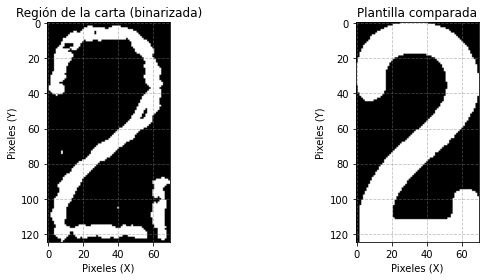

In [18]:
number_templates, suit_templates = load_templates()
templ_bin = binarize_template(number_templates['Two'][0])
resized = cv2.resize(binarize_region(number_img), (templ_bin.shape[1], templ_bin.shape[0]))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(resized, cmap='gray')
axs[0].set_title("Región de la carta (binarizada)")
axs[0].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(templ_bin, cmap='gray')
axs[1].set_title("Plantilla comparada")
axs[1].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()

## 14. Validación de proporción de la carta

La función `is_valid_card_proportion` verifica si la carta rectificada tiene una proporción (alto/ancho) razonable.

Esto sirve para descartar deformaciones por errores en el proceso de recorte o warping.

La proporción esperada es aproximadamente 1:1. Se permite un margen (`jump_ratio`) para evitar rechazar cartas ligeramente distorsionadas.

Devuelve `True` si la proporción está dentro del rango aceptable.

In [19]:
def is_valid_card_proportion(warped_img, jump_ratio=0.7, debug=False):
    h, w = warped_img.shape[:2]
    ratio = h / w if w != 0 else 0

    res = (1 - jump_ratio <= ratio) and (ratio <= 1 + jump_ratio)
    
    if debug:
        print(f"[DEBUG] Dimensiones carta: {w}x{h} | Ratio: {ratio:.2f} | {1-jump_ratio } <= {ratio:.2f} <= {1 + jump_ratio}\n\tResultado:{res}")

    return res

## 15. Ejecución principal del sistema (`main`)

Esta función coordina todo el flujo del reconocimiento:

1. Carga la imagen desde disco.
1. La preprocesa para detectar bordes.
1. Encuentra los contornos de las cartas.
1. Para cada carta detectada:
- Se corrige la perspectiva (warp).
- Se rota para asegurar la orientación correcta.
- Se valida la proporción.
- Se extraen las regiones del número y el símbolo.
- Se comparan estas regiones con plantillas para identificar la carta.

Permite activar modo `debug` para visualizar cada paso.

Devuelve el número y el palo detectados de la primera carta válida encontrada en la imagen.

In [20]:
def main(path, debug=False, draw_predictions=True, show_result=True):
    image = cv2.imread(path)
    original = image.copy()

    edges = preprocess_image(image)
    if debug:
        plt.figure(figsize=(8, 6))
        plt.imshow(edges, cmap='gray')
        plt.title("Imagen Binarizada para Contornos")
        plt.axis('off')
        plt.show()
    card_contours = find_card_contours(edges)
     # Visualizar contornos
    if debug:
        drawn = image.copy()
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.show()

        drawn = np.zeros_like(image)

        # ✅ Dibujar contornos detectados en verde
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)

        # 🎨 Mostrar
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas (Sobre Fondo Negro)")
        plt.axis("off")
        plt.show()

    if debug:
        print(f"🟢 Cartas detectadas: {len(card_contours)}")

    number_templates, suit_templates = load_templates()
    detected_cards = []

    for i, contour in enumerate(card_contours):
        warped = warp_card(image, contour)
        if warped is None:
            if debug:
                print(f"❌ Contorno {i} no pudo ser transformado.")
            continue

        warped = correct_card_orientation(warped, debug)
        if warped is None or not is_valid_card_proportion(warped, debug=debug):
            if debug:
                print(f"⚠️ Contorno {i} descartado por proporción.")
            continue

        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Carta warped")
            plt.show()
            
        number_region, suit_region = extract_number_suit_region(warped, debug=debug)
        if debug:
            print("Template mathing:")
        if number_region is not None and suit_region is not None:
            number = match_template(number_region, number_templates, debug=debug)
            suit = match_template(suit_region, suit_templates, debug=debug)
            detected_cards.append((contour, number, suit))

            if debug:
                print(f"🃏 Carta {i + 1}: {number} de {suit}")
        else:
            if debug:
                print(f"❌ Carta {i + 1}: no se pudo extraer número y palo.")

    # 🔤 Dibujar los resultados sobre la imagen original
    if draw_predictions:
        for i, (contour, number, suit) in enumerate(detected_cards):
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = contour[0][0]

            label = f"{number} of {suit}"
            # Obtener tamaño del texto (retorna tamaño y línea base)
            (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)

            # Ajustar el punto de inicio para centrar horizontalmente
            text_x = cx - text_width // 2
            text_y = cy + text_height // 2  # Puedes ajustar el Y si quieres moverlo arriba/abajo

            # Dibujar texto centrado
            cv2.putText(original, label, (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3, cv2.LINE_AA)
            cv2.drawContours(original, [contour], -1, (0, 255, 0), 2)

    # Mostrar la imagen final
    if show_result:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.axis("off")
        plt.show()

    # Devolver resultados en forma de lista
    return [(number, suit) for _, number, suit in detected_cards]


In [27]:
results = main("Fotos/fotos_multiples/5D6S2.jpg", debug=True)
print(results)
for i, (number, suit) in enumerate(results):
    print(f"Carta {i + 1}: {number} de {suit}")

AttributeError: 'NoneType' object has no attribute 'copy'

## Experimentaciones

In [25]:
results = main("Fotos/fotos_multiples/5D6S2.jpg", debug=True)
print(results)
for i, (number, suit) in enumerate(results):
    print(f"Carta {i + 1}: {number} de {suit}")

NameError: name 'main' is not defined

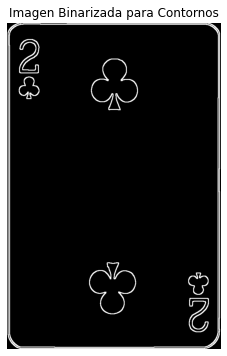

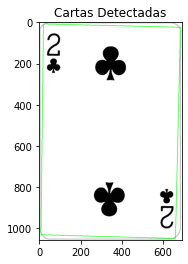

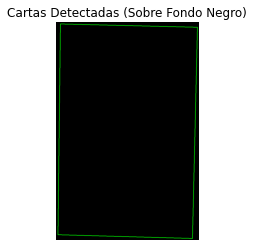

🟢 Cartas detectadas: 1
Dimensiones - Alto: 1023, Ancho: 662
[DEBUG] Dimensiones carta: 662x1023 | Ratio: 1.55 | 0.30000000000000004 <= 1.55 <= 1.7
	Resultado:True


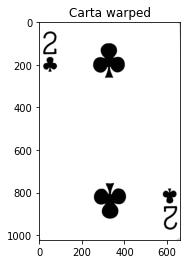

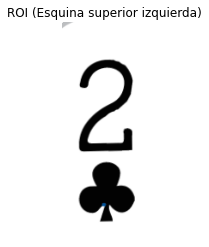

Contornos totales: 3 | Filtrados: 2


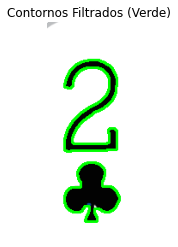

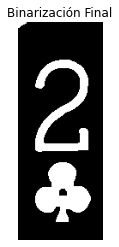

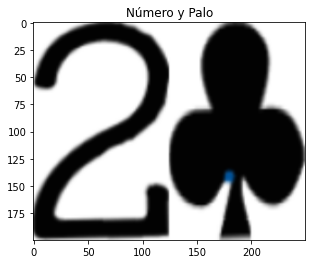

Template mathing:


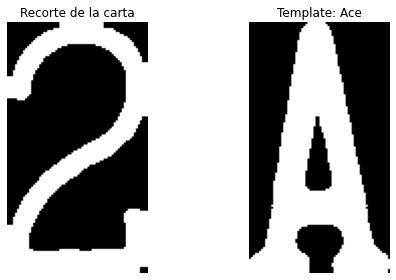

Ace: score = -0.0775


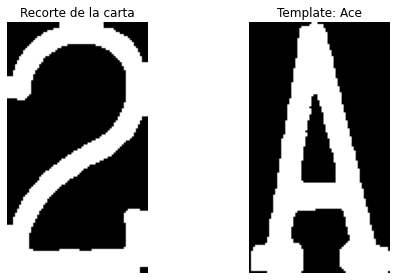

Ace: score = -0.0282


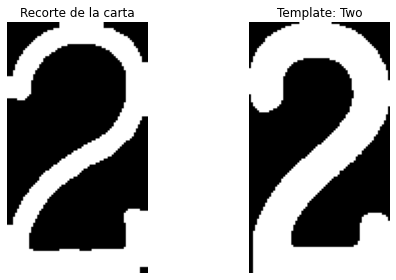

Two: score = 0.6587


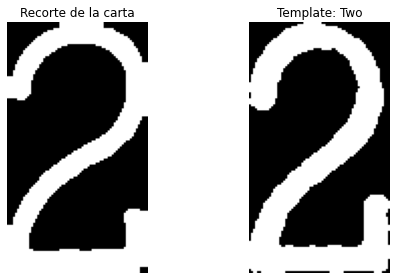

Two: score = 0.6969


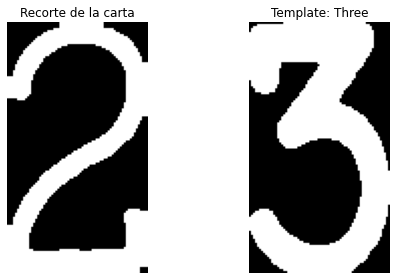

Three: score = 0.0934


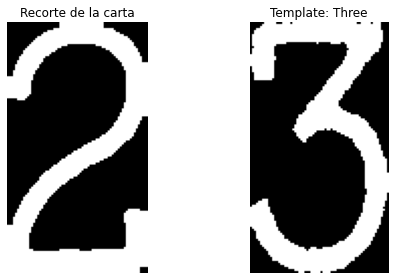

Three: score = 0.1270


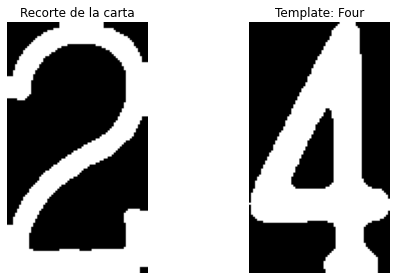

Four: score = -0.2057


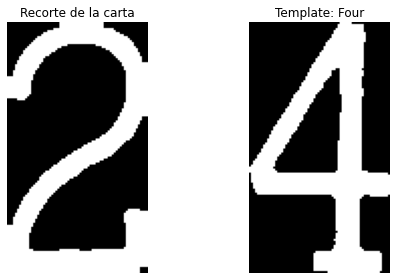

Four: score = -0.1130


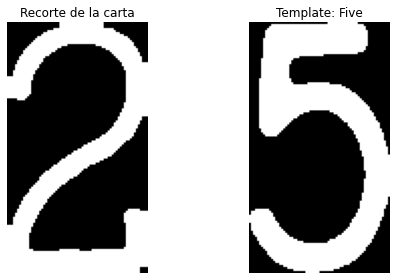

Five: score = 0.0945


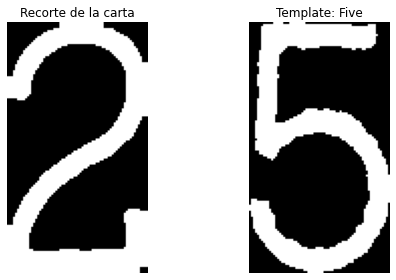

Five: score = 0.1579


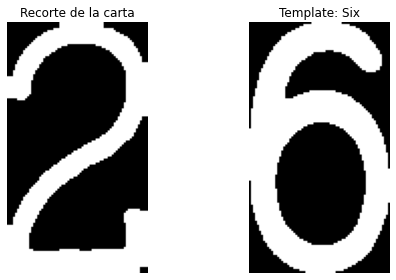

Six: score = 0.0785


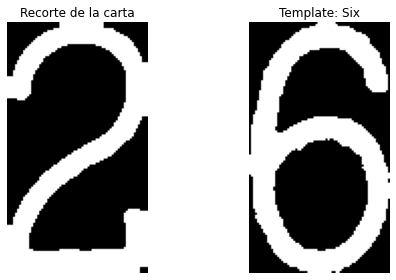

Six: score = 0.1527


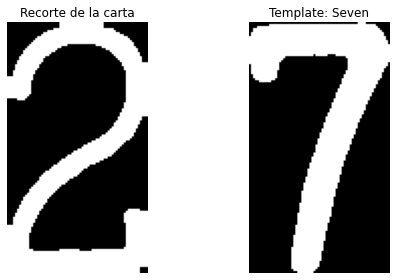

Seven: score = 0.0856


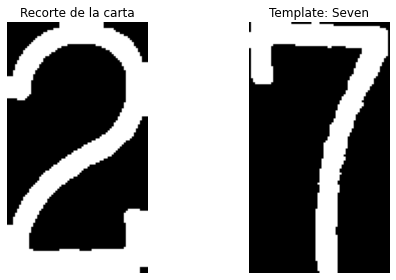

Seven: score = 0.0866


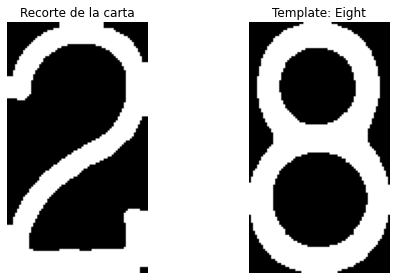

Eight: score = 0.2264


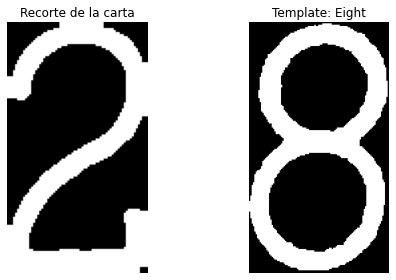

Eight: score = 0.3116


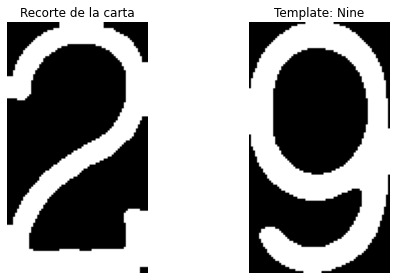

Nine: score = 0.2162


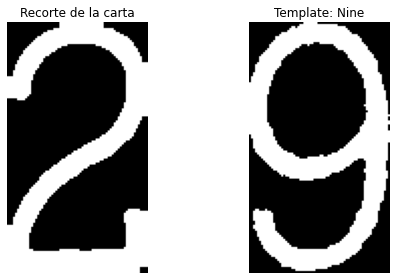

Nine: score = 0.3549


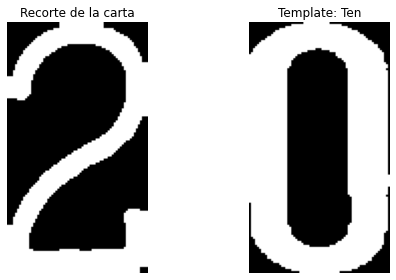

Ten: score = 0.2602


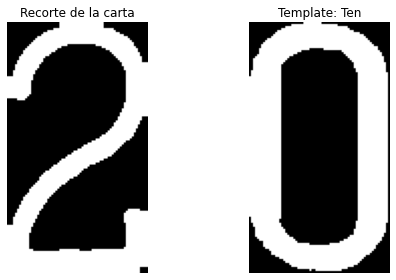

Ten: score = 0.2729


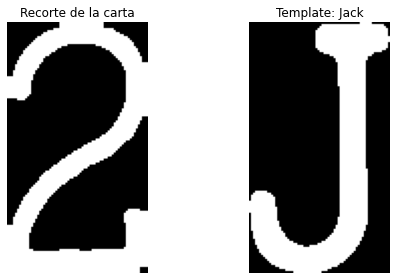

Jack: score = 0.0771


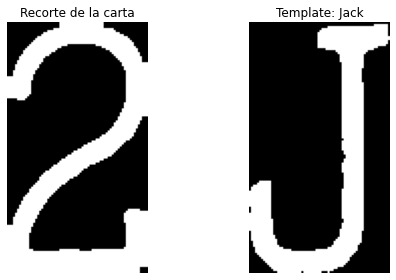

Jack: score = 0.1278


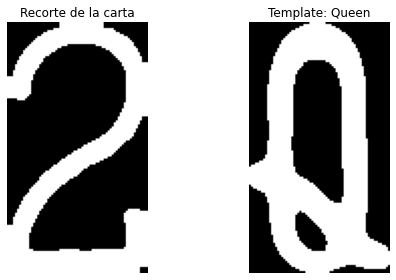

Queen: score = -0.0449


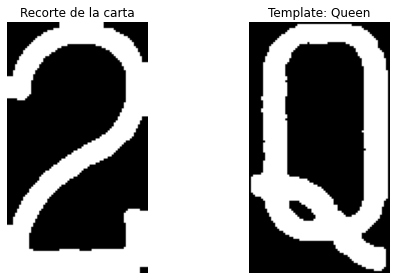

Queen: score = 0.1165


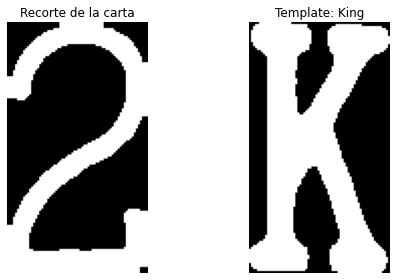

King: score = 0.0411


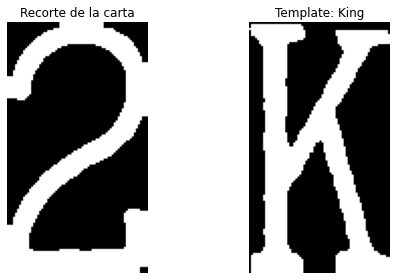

King: score = 0.0671


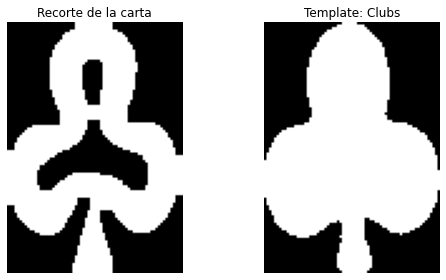

Clubs: score = 0.7129


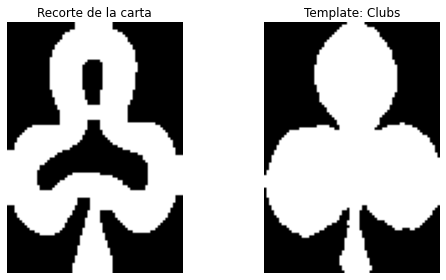

Clubs: score = 0.6391


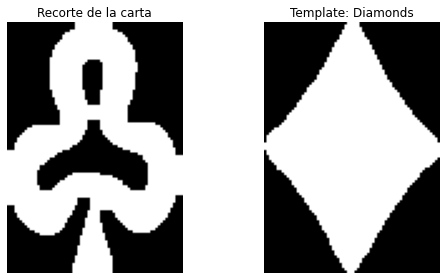

Diamonds: score = 0.3573


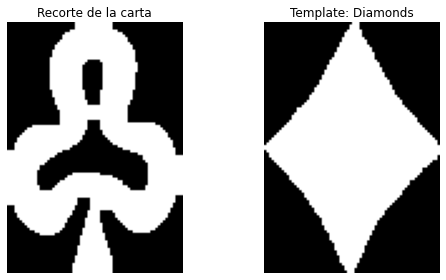

Diamonds: score = 0.3384


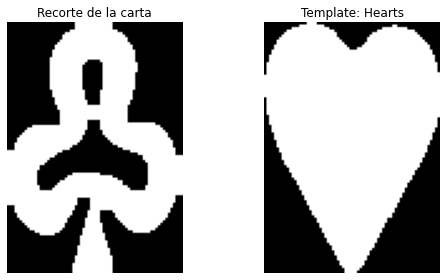

Hearts: score = 0.0764


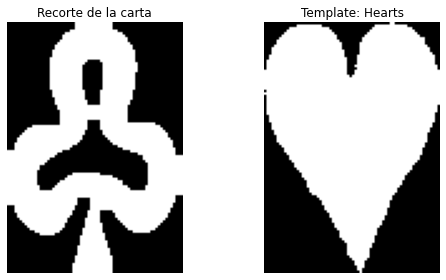

Hearts: score = 0.0277


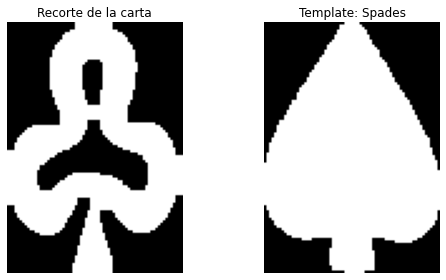

Spades: score = 0.5710


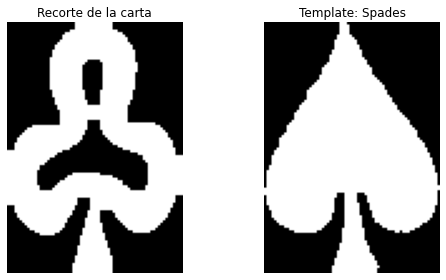

Spades: score = 0.5547
🃏 Carta 1: Two de Clubs


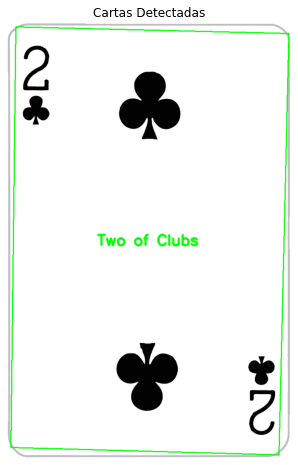

Carta 1: Two de Clubs


In [21]:
results = main("Fotos/fotos_sencillas/2C.PNG", debug=True)

for i, (number, suit) in enumerate(results):
    print(f"Carta {i + 1}: {number} de {suit}")

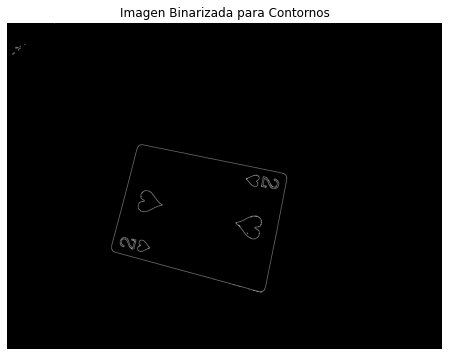

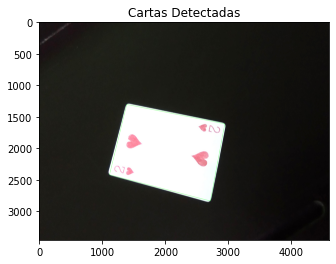

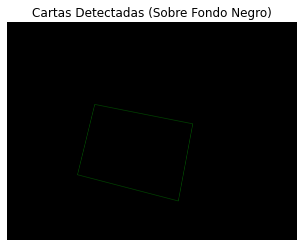

🟢 Cartas detectadas: 1
Dimensiones - Alto: 1244, Ancho: 1655
Rotando la carta 90° en sentido horario
[DEBUG] Dimensiones carta: 1244x1655 | Ratio: 1.33 | 0.30000000000000004 <= 1.33 <= 1.7
	Resultado:True


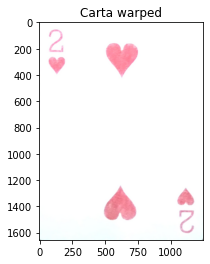

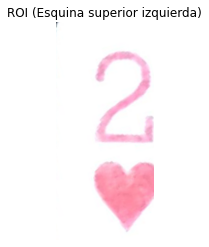

Contornos totales: 18 | Filtrados: 2


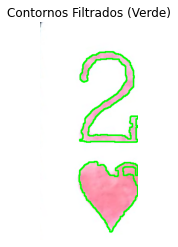

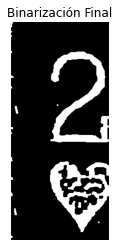

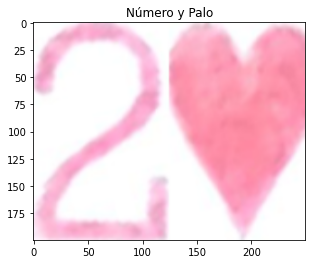

Template mathing:


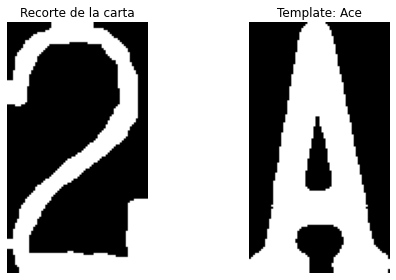

Ace: score = -0.0691


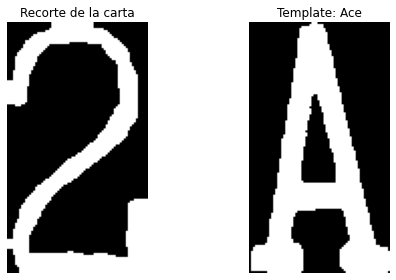

Ace: score = -0.0265


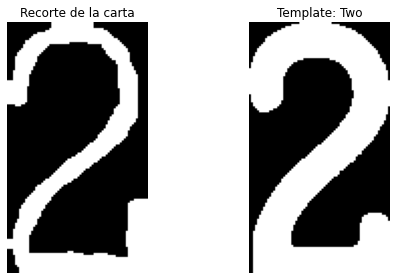

Two: score = 0.6251


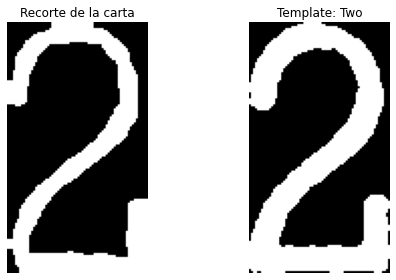

Two: score = 0.7466


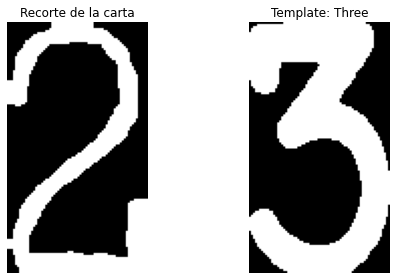

Three: score = 0.1108


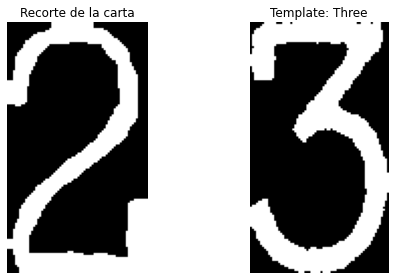

Three: score = 0.1616


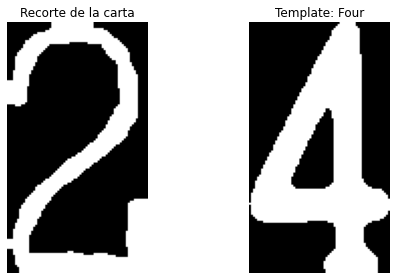

Four: score = -0.1481


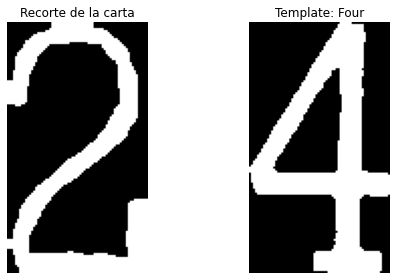

Four: score = -0.0783


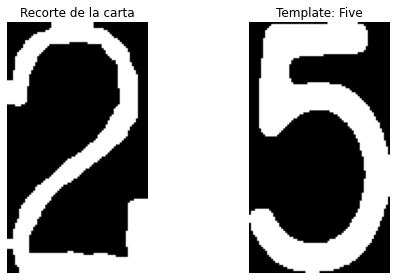

Five: score = 0.1034


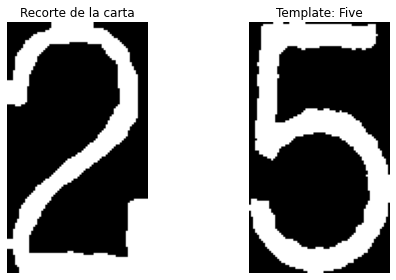

Five: score = 0.1752


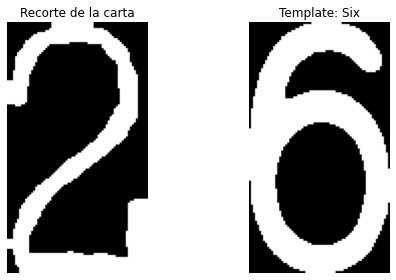

Six: score = 0.0651


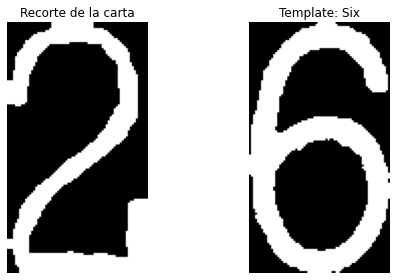

Six: score = 0.1104


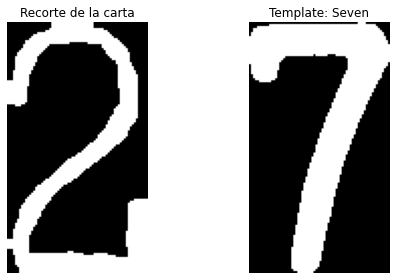

Seven: score = 0.1351


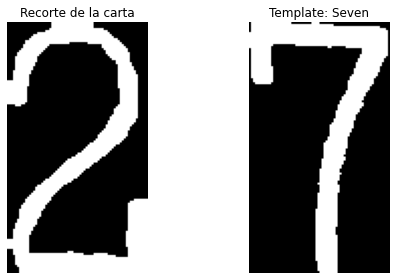

Seven: score = 0.1363


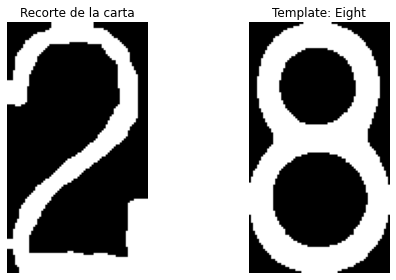

Eight: score = 0.2890


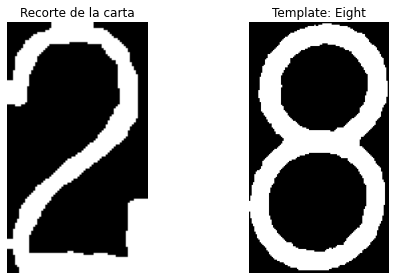

Eight: score = 0.2324


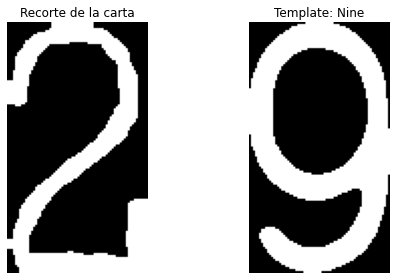

Nine: score = 0.1913


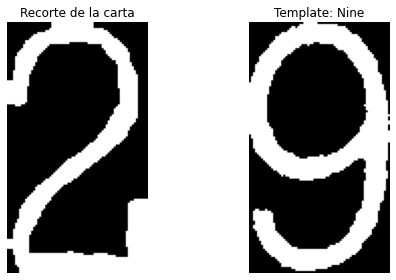

Nine: score = 0.3342


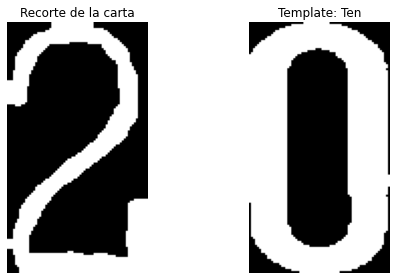

Ten: score = 0.2456


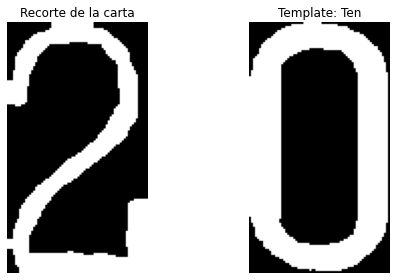

Ten: score = 0.2470


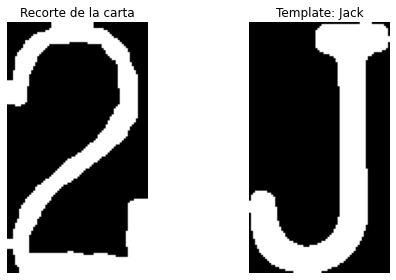

Jack: score = 0.0974


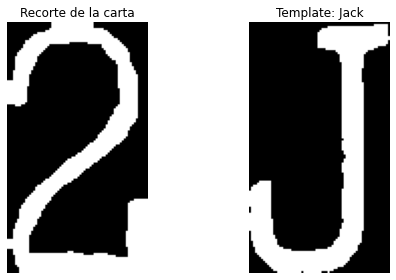

Jack: score = 0.1327


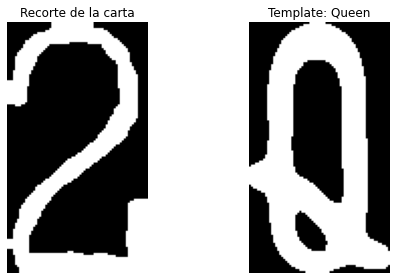

Queen: score = -0.0054


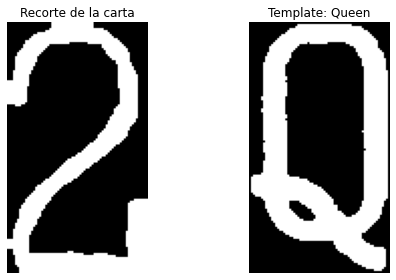

Queen: score = 0.0400


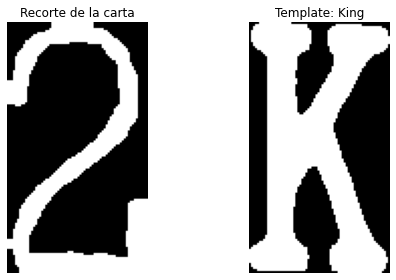

King: score = 0.0071


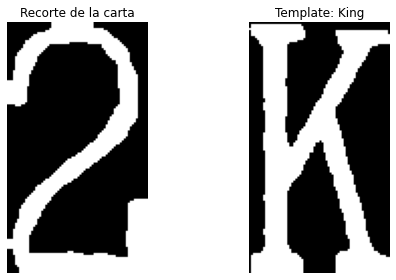

King: score = 0.0634


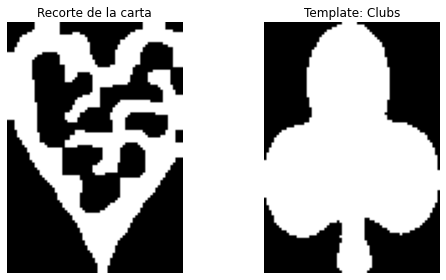

Clubs: score = 0.0673


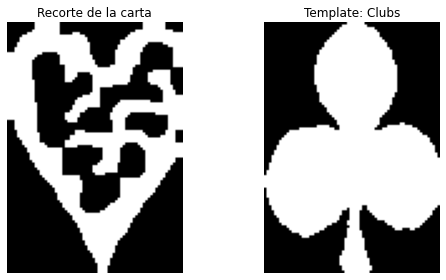

Clubs: score = 0.0751


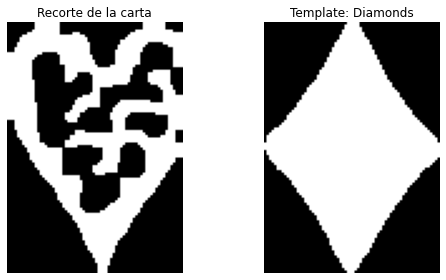

Diamonds: score = 0.2031


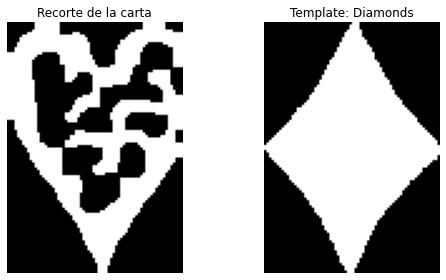

Diamonds: score = 0.1862


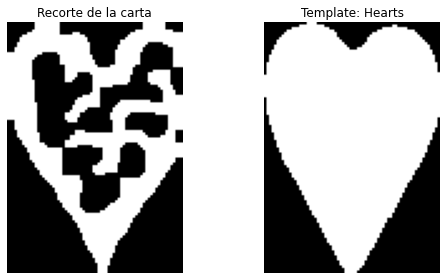

Hearts: score = 0.4303


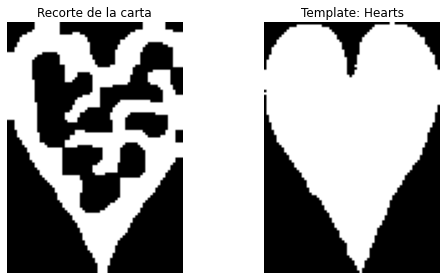

Hearts: score = 0.4054


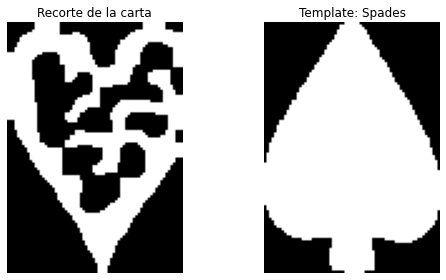

Spades: score = 0.0175


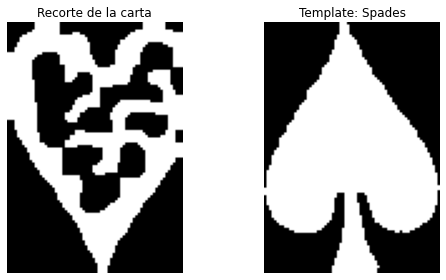

Spades: score = 0.0326
🃏 Carta 1: Two de Hearts


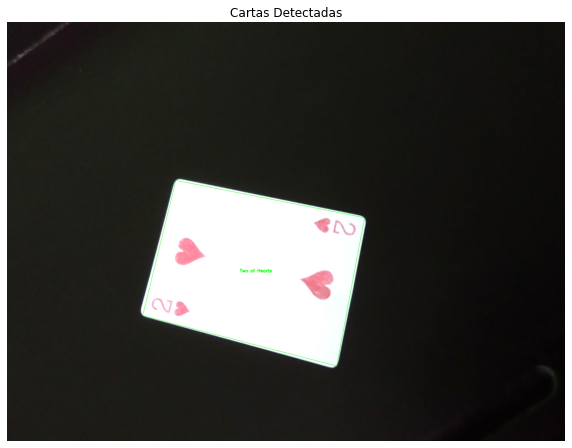

[('Two', 'Hearts')]

In [22]:
main("Fotos/Imagenes/2H27.jpg", debug=True)

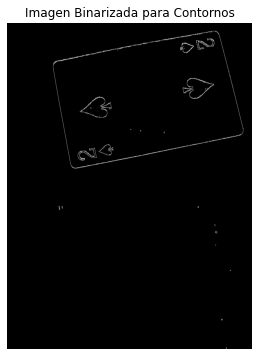

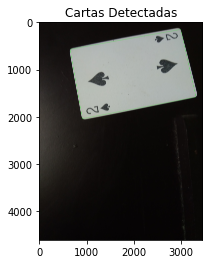

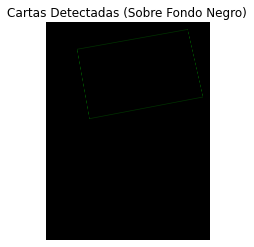

🟢 Cartas detectadas: 1
Dimensiones - Alto: 1490, Ancho: 2435
Rotando la carta 90° en sentido horario
[DEBUG] Dimensiones carta: 1490x2435 | Ratio: 1.63 | 0.30000000000000004 <= 1.63 <= 1.7
	Resultado:True


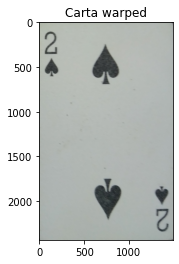

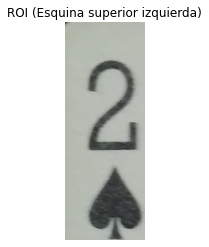

Contornos totales: 220 | Filtrados: 36


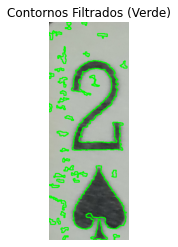

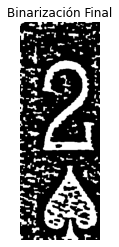

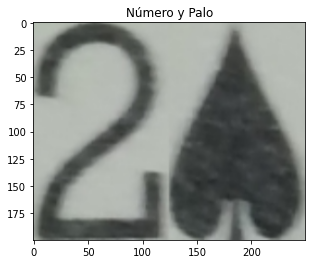

Template mathing:


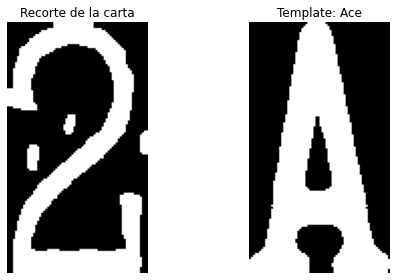

Ace: score = -0.0317


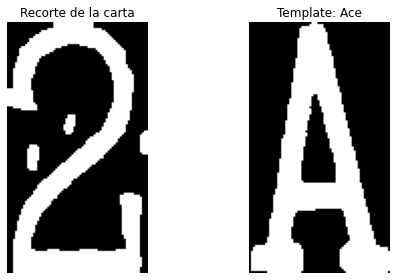

Ace: score = -0.0089


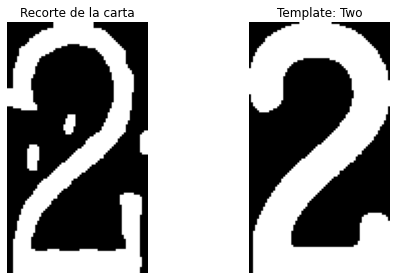

Two: score = 0.6068


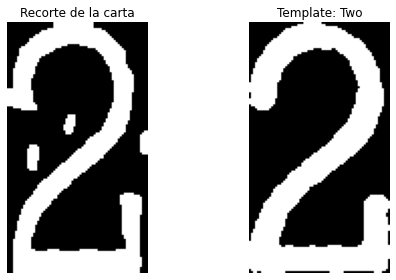

Two: score = 0.7497


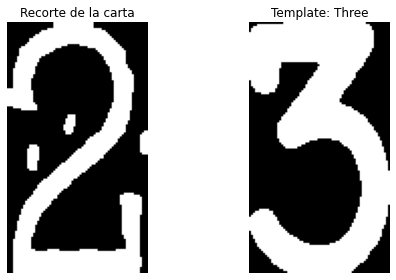

Three: score = 0.1622


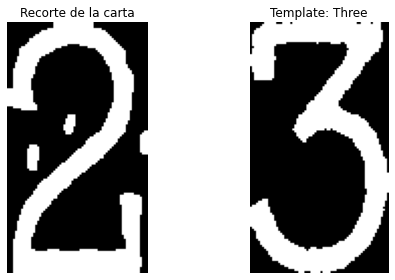

Three: score = 0.1888


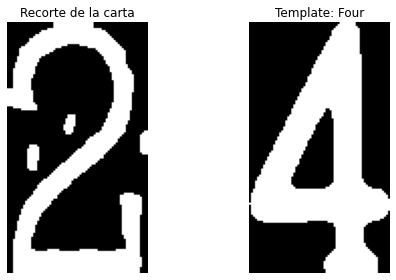

Four: score = -0.0551


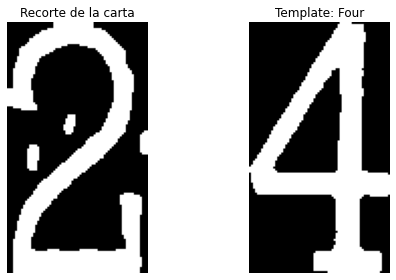

Four: score = -0.0140


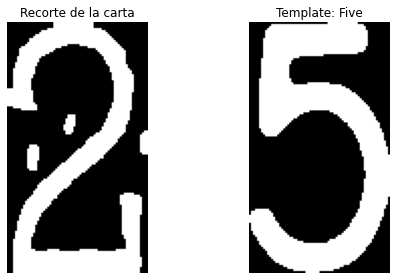

Five: score = 0.1701


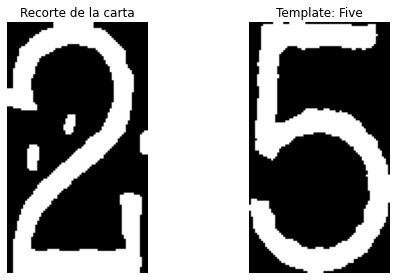

Five: score = 0.2407


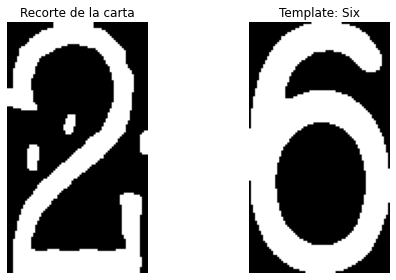

Six: score = 0.1495


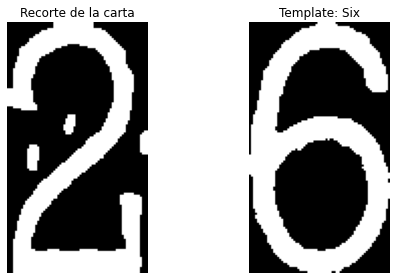

Six: score = 0.1893


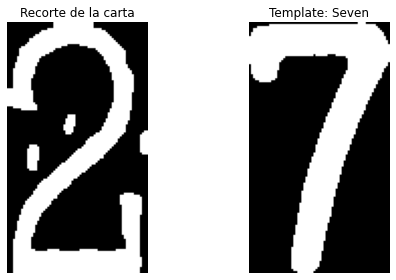

Seven: score = 0.1677


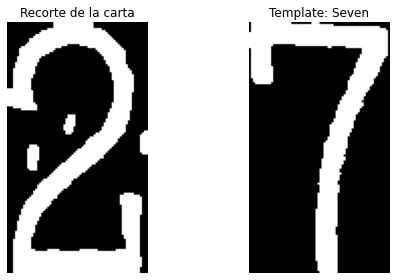

Seven: score = 0.1433


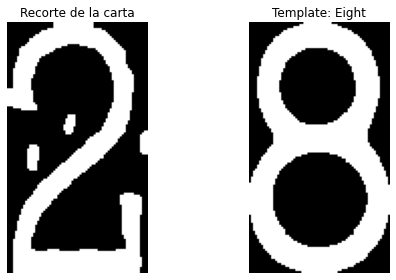

Eight: score = 0.3786


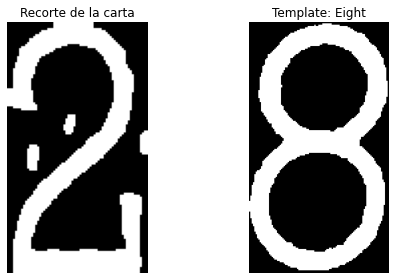

Eight: score = 0.2666


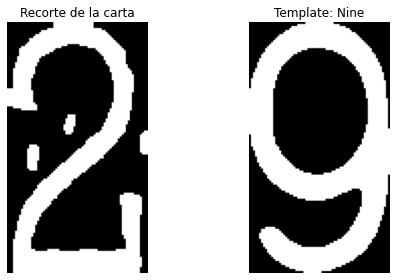

Nine: score = 0.2663


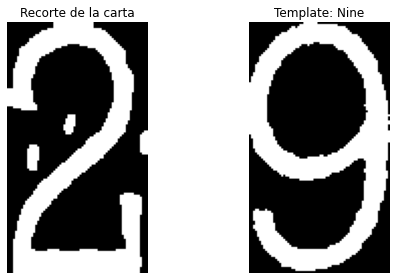

Nine: score = 0.3620


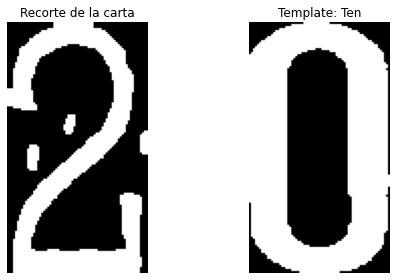

Ten: score = 0.2894


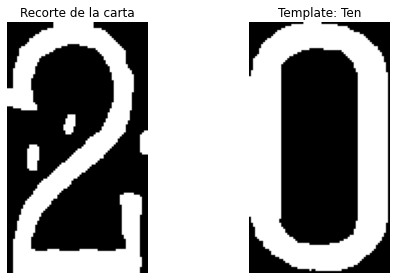

Ten: score = 0.2845


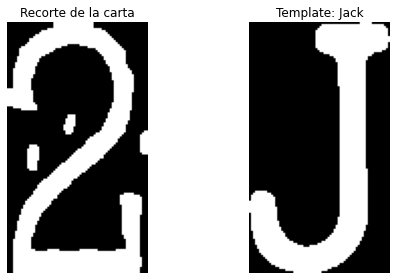

Jack: score = 0.1389


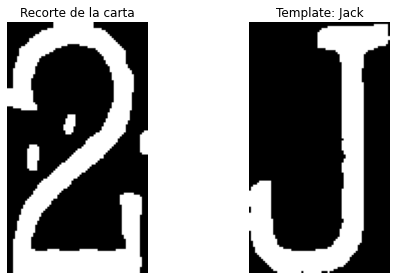

Jack: score = 0.1626


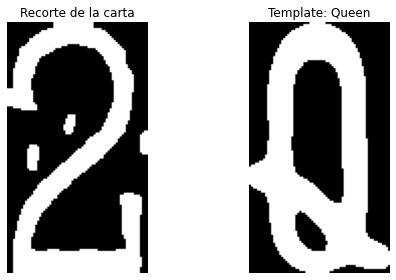

Queen: score = 0.1102


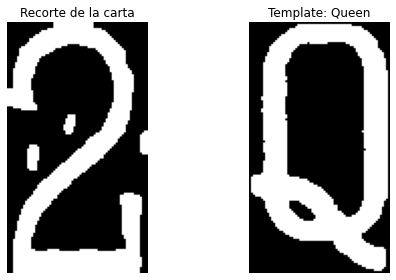

Queen: score = 0.0617


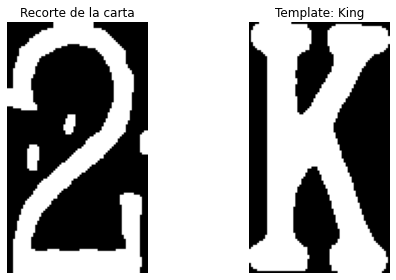

King: score = 0.1063


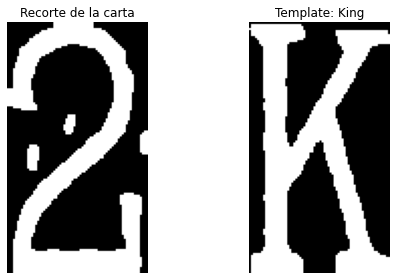

King: score = 0.1409


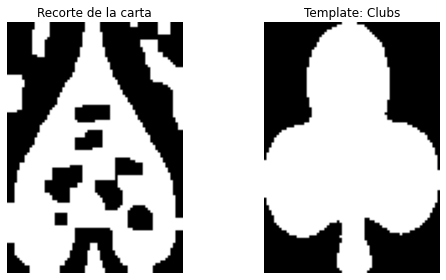

Clubs: score = 0.2025


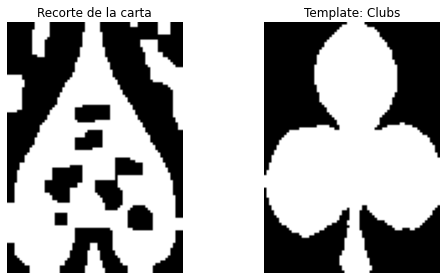

Clubs: score = 0.1815


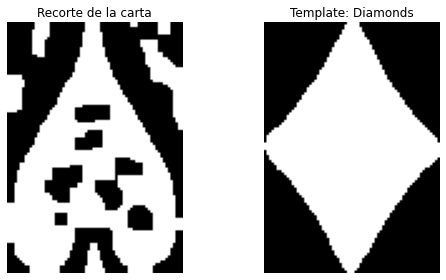

Diamonds: score = 0.1395


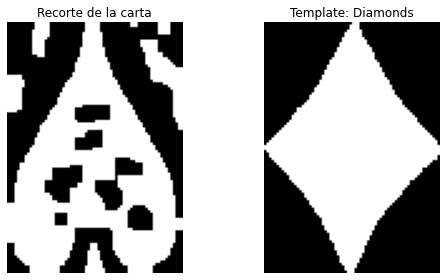

Diamonds: score = 0.1701


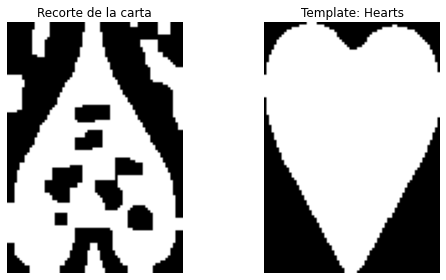

Hearts: score = -0.0763


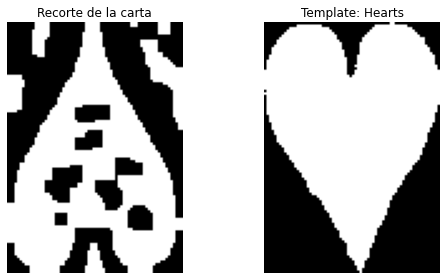

Hearts: score = -0.1045


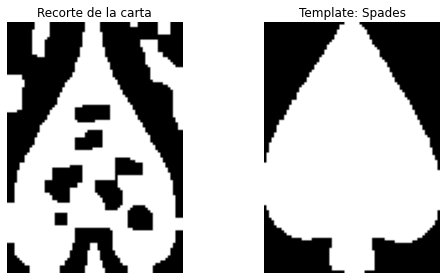

Spades: score = 0.1910


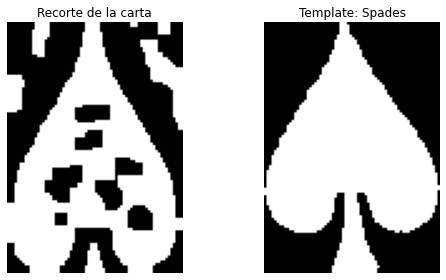

Spades: score = 0.2741
🃏 Carta 1: Two de Spades


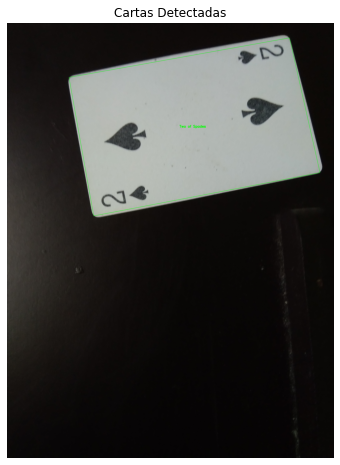

[('Two', 'Spades')]

In [23]:
main("Fotos/Imagenes/2S0.jpg", debug=True)

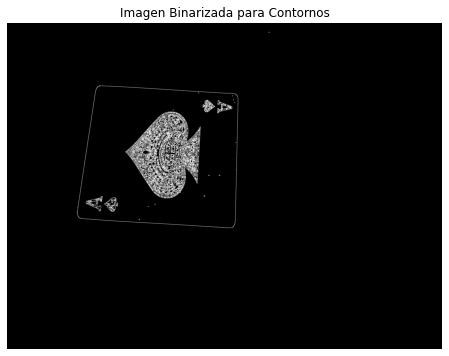

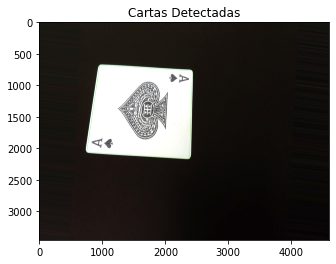

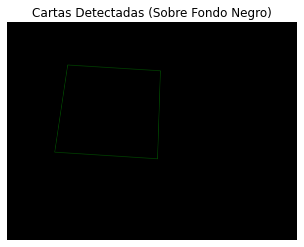

🟢 Cartas detectadas: 1
Dimensiones - Alto: 1397, Ancho: 1637
Rotando la carta 90° en sentido horario
[DEBUG] Dimensiones carta: 1397x1637 | Ratio: 1.17 | 0.30000000000000004 <= 1.17 <= 1.7
	Resultado:True


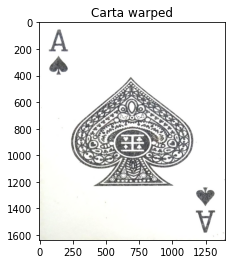

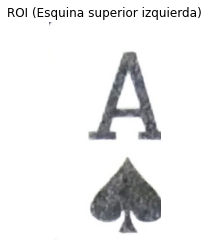

Contornos totales: 4 | Filtrados: 2


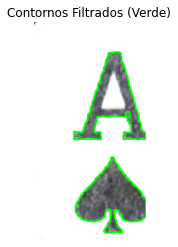

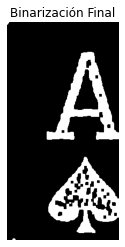

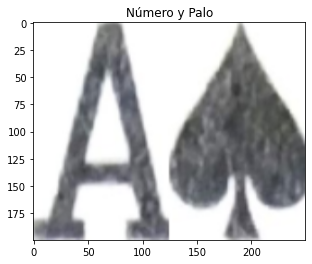

Template mathing:


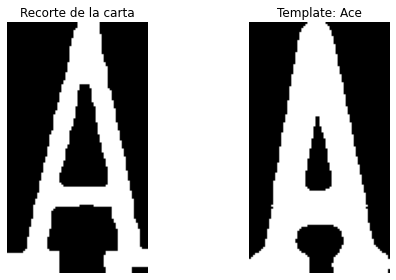

Ace: score = 0.5067


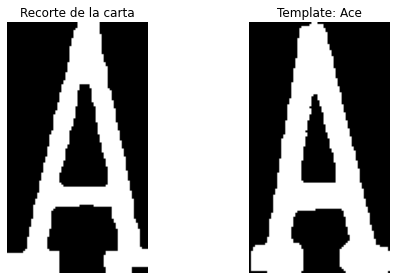

Ace: score = 0.5234


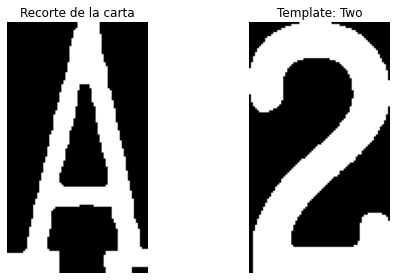

Two: score = 0.0816


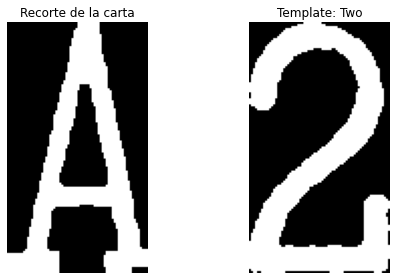

Two: score = 0.0653


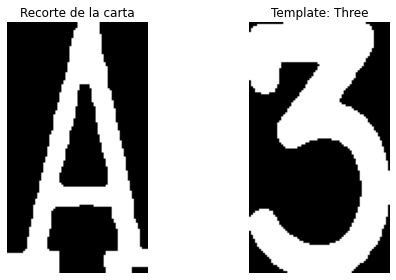

Three: score = 0.1388


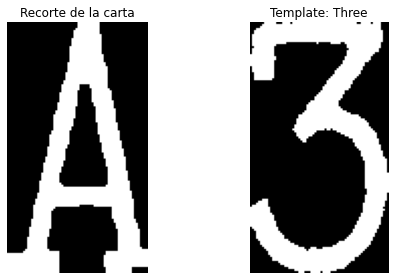

Three: score = 0.0093


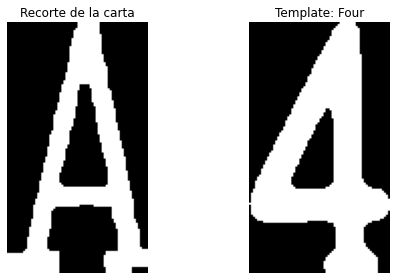

Four: score = 0.3695


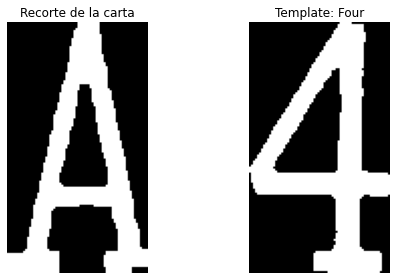

Four: score = 0.2001


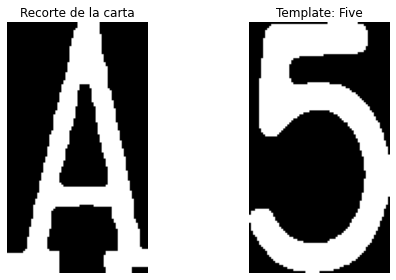

Five: score = -0.0407


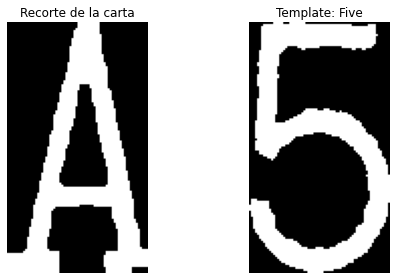

Five: score = -0.0750


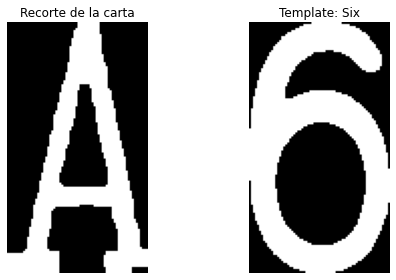

Six: score = -0.1132


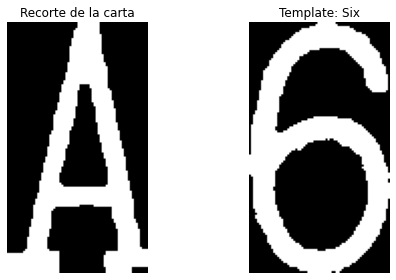

Six: score = -0.1015


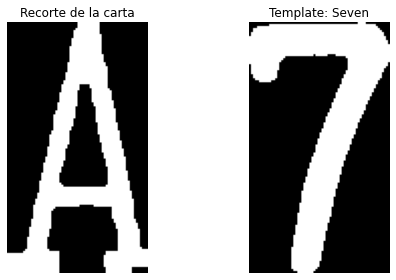

Seven: score = -0.1543


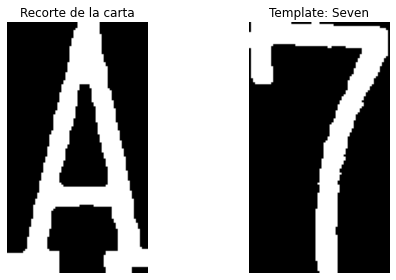

Seven: score = -0.1723


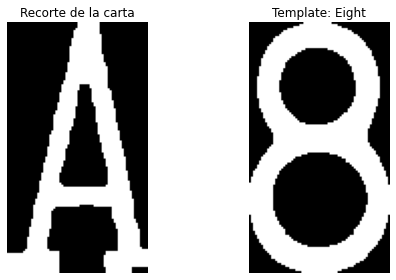

Eight: score = -0.0748


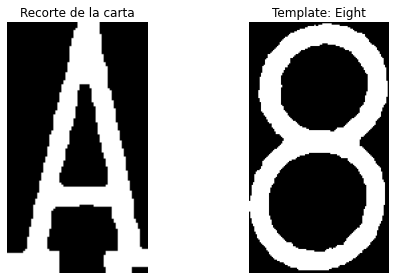

Eight: score = -0.0884


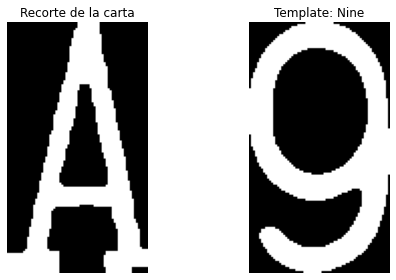

Nine: score = -0.0702


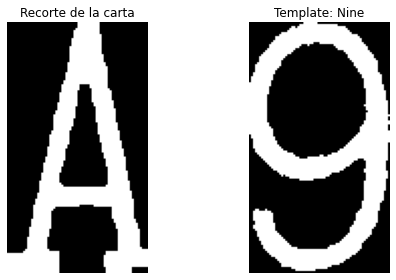

Nine: score = -0.1542


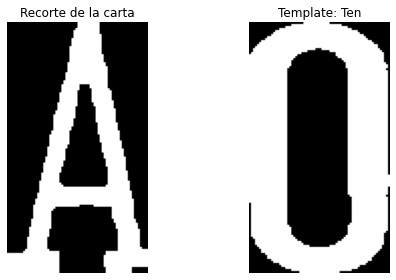

Ten: score = -0.1476


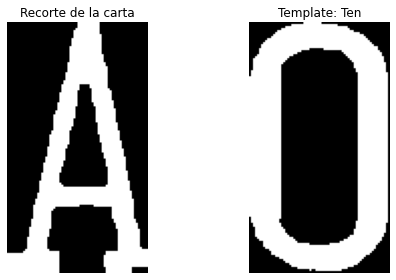

Ten: score = -0.2426


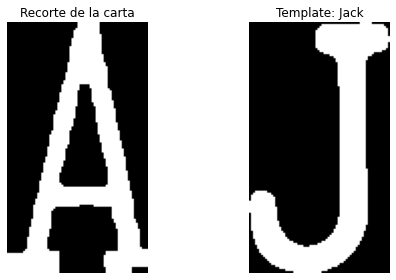

Jack: score = 0.1637


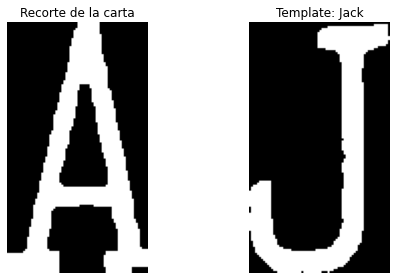

Jack: score = 0.1271


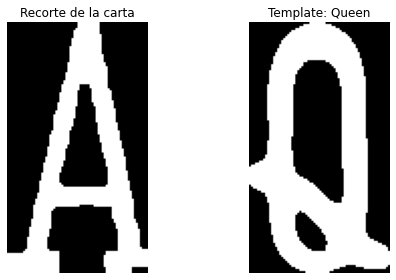

Queen: score = 0.2057


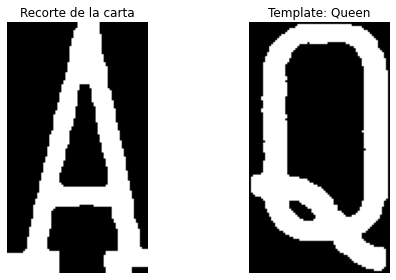

Queen: score = -0.1503


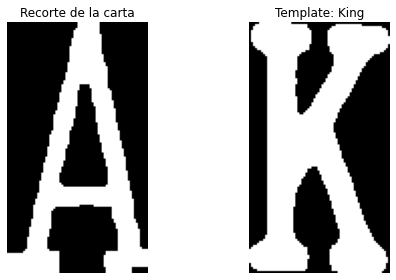

King: score = 0.0857


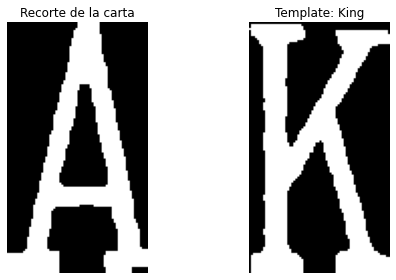

King: score = 0.0800


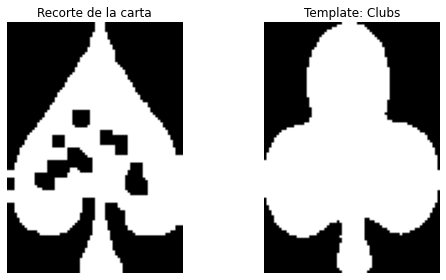

Clubs: score = 0.6624


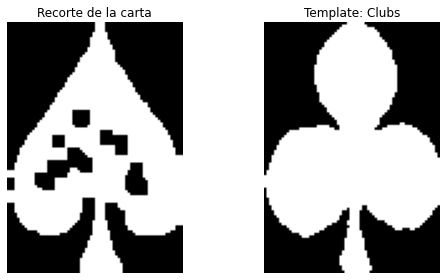

Clubs: score = 0.6504


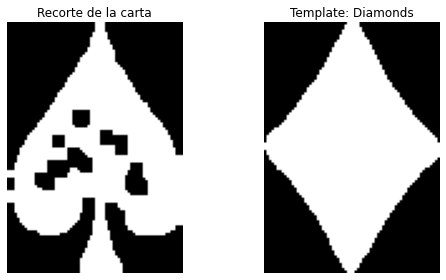

Diamonds: score = 0.4845


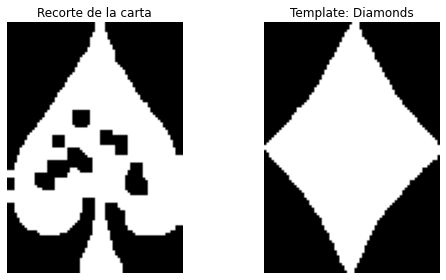

Diamonds: score = 0.5081


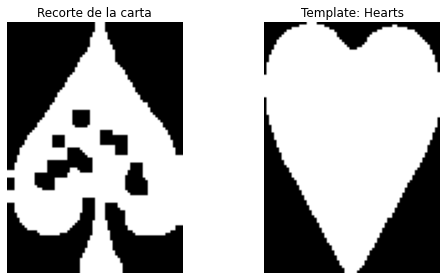

Hearts: score = 0.0913


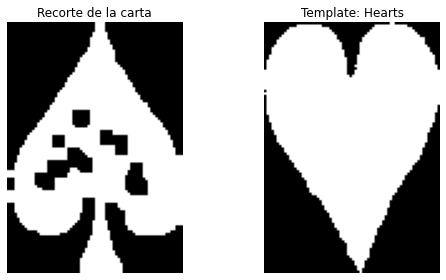

Hearts: score = 0.0409


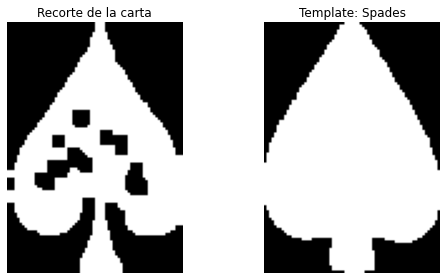

Spades: score = 0.6792


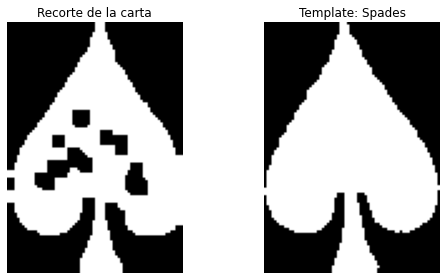

Spades: score = 0.7060
🃏 Carta 1: Ace de Spades


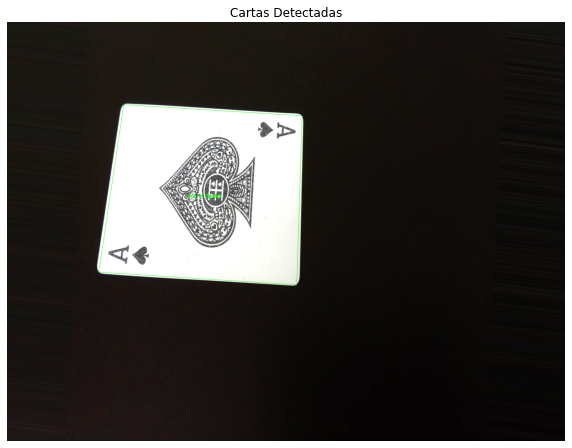

[('Ace', 'Spades')]

In [24]:
main("Fotos/Imagenes/AS1.jpg", debug=True)

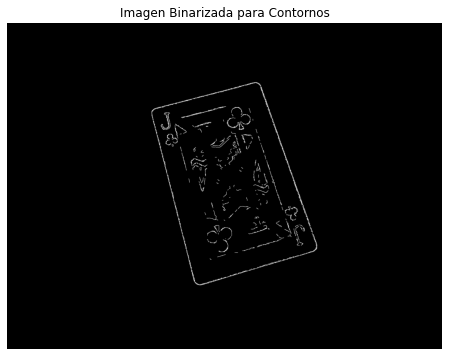

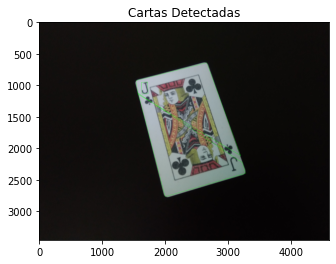

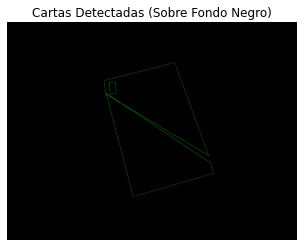

🟢 Cartas detectadas: 3
Dimensiones - Alto: 1696, Ancho: 1991
Rotando la carta 90° en sentido horario
[DEBUG] Dimensiones carta: 1696x1991 | Ratio: 1.17 | 0.30000000000000004 <= 1.17 <= 1.7
	Resultado:True


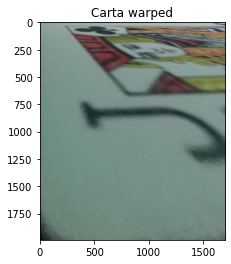

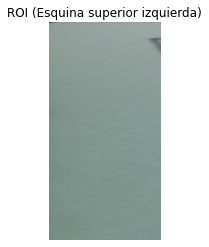

Contornos totales: 385 | Filtrados: 51


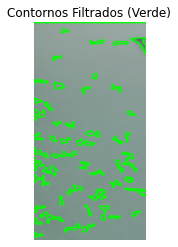

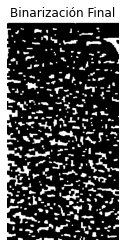

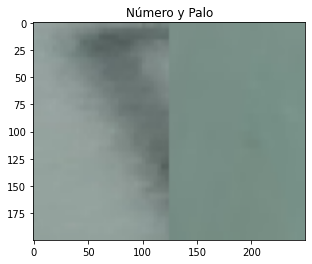

Template mathing:


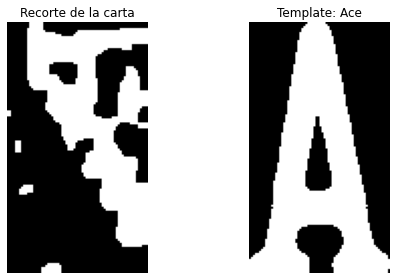

Ace: score = 0.0601


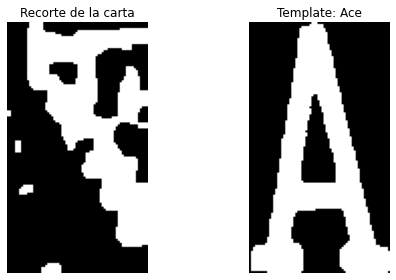

Ace: score = 0.0601


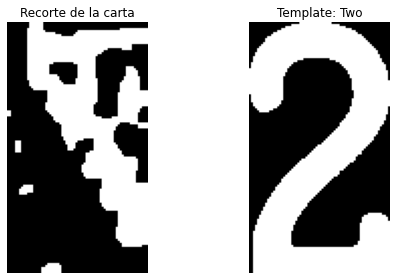

Two: score = -0.0047


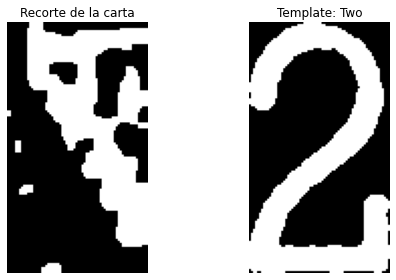

Two: score = 0.0249


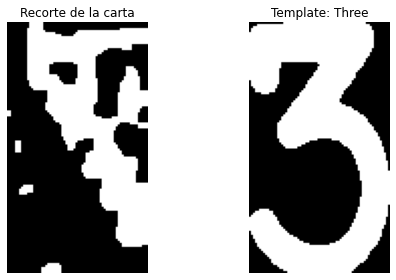

Three: score = 0.2564


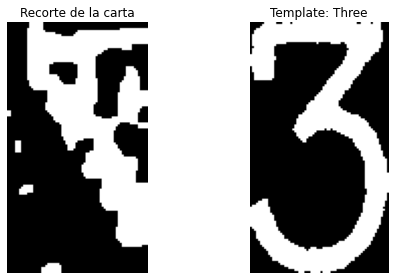

Three: score = 0.0988


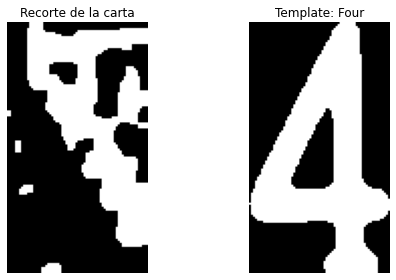

Four: score = 0.0638


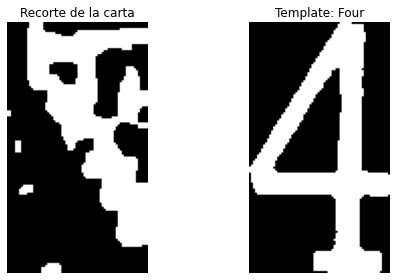

Four: score = 0.0091


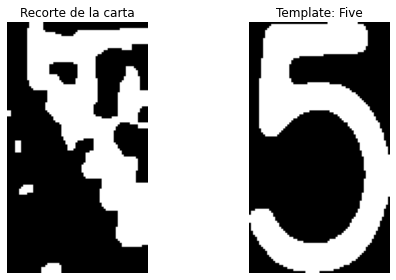

Five: score = 0.1564


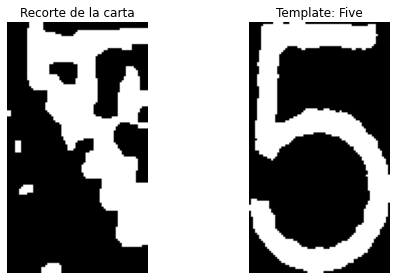

Five: score = 0.1030


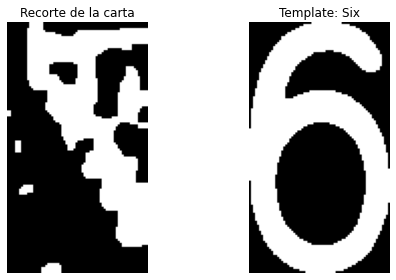

Six: score = 0.0630


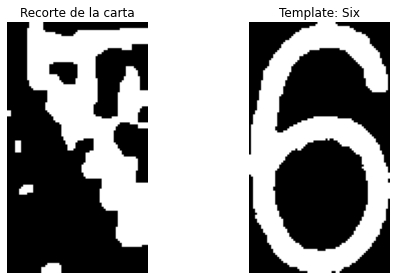

Six: score = 0.0820


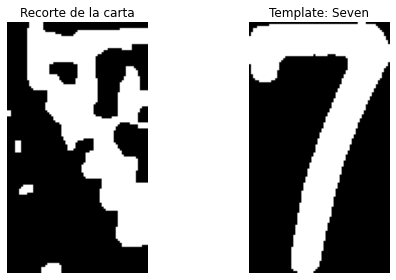

Seven: score = 0.0643


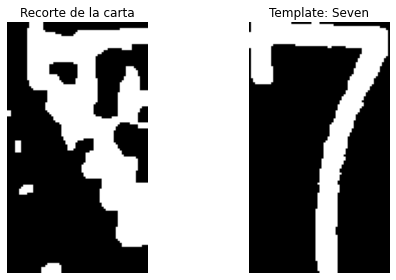

Seven: score = 0.0196


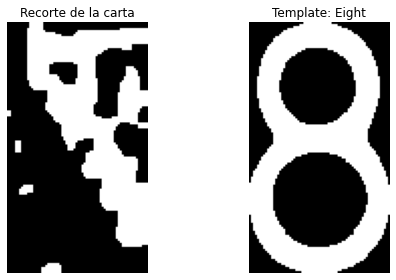

Eight: score = 0.1008


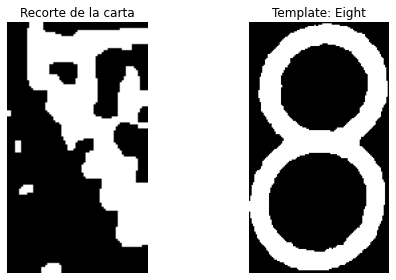

Eight: score = 0.1377


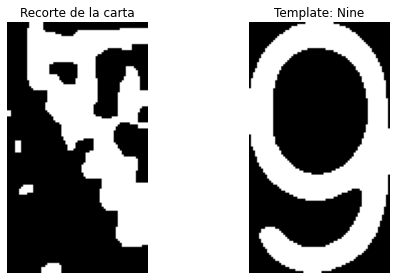

Nine: score = 0.0237


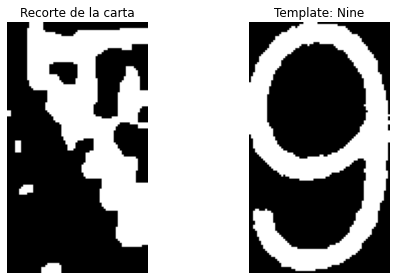

Nine: score = 0.0186


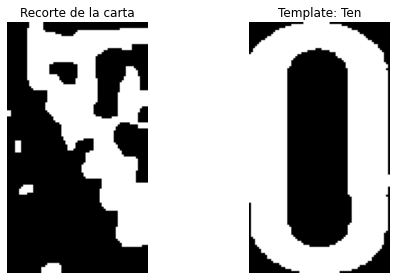

Ten: score = -0.0121


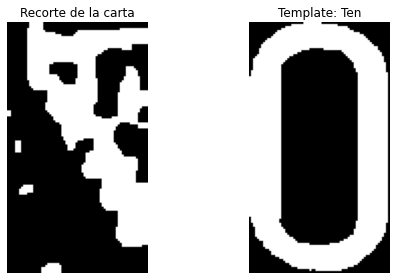

Ten: score = -0.0037


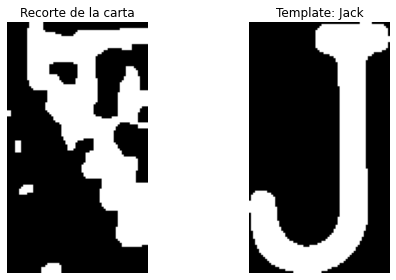

Jack: score = 0.0214


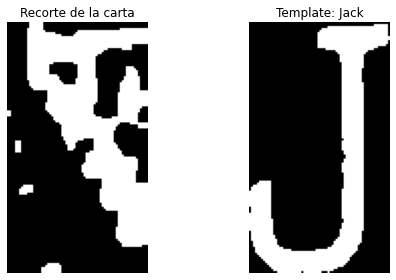

Jack: score = 0.0223


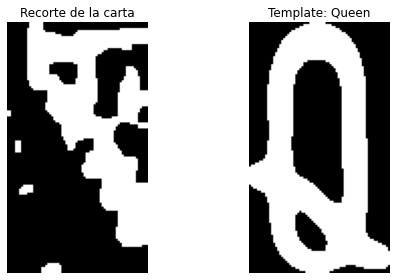

Queen: score = -0.0880


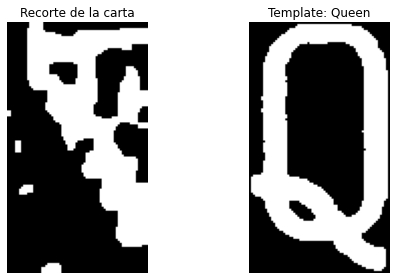

Queen: score = -0.0732


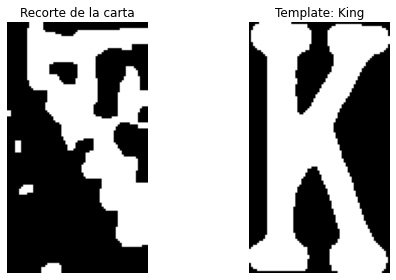

King: score = -0.0150


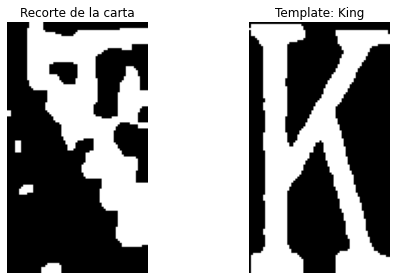

King: score = 0.0098


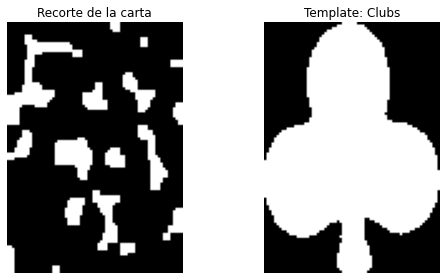

Clubs: score = -0.0208


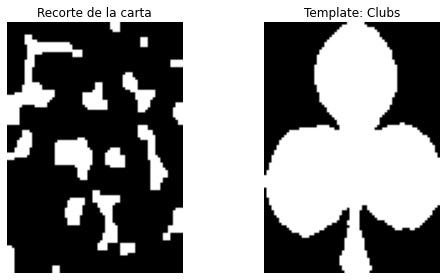

Clubs: score = -0.0098


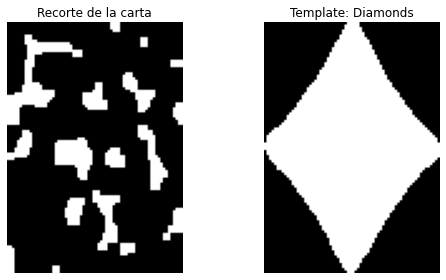

Diamonds: score = 0.0904


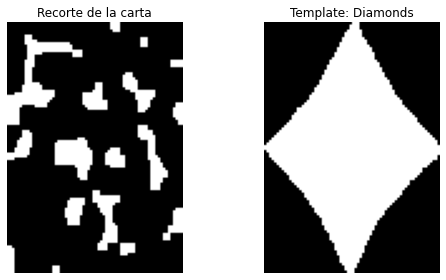

Diamonds: score = 0.0871


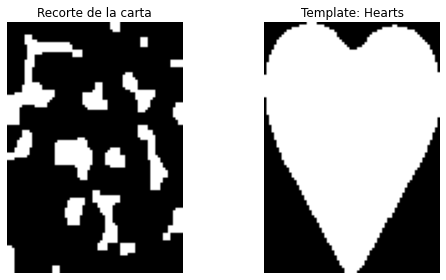

Hearts: score = 0.1595


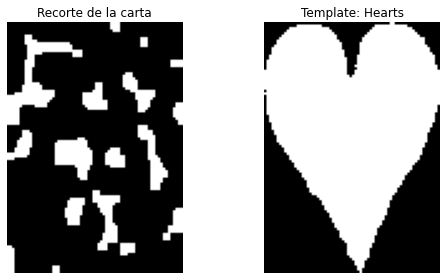

Hearts: score = 0.1680


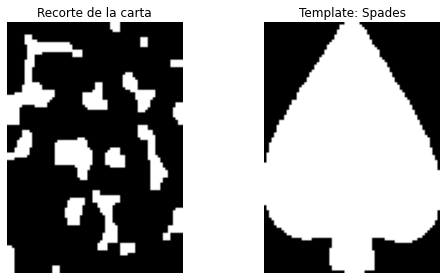

Spades: score = 0.0144


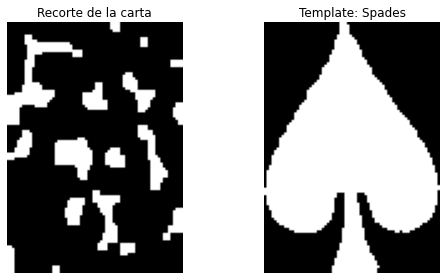

Spades: score = -0.0534
🃏 Carta 1: Three de Hearts
Dimensiones - Alto: 184, Ancho: 98
[DEBUG] Dimensiones carta: 98x184 | Ratio: 1.88 | 0.30000000000000004 <= 1.88 <= 1.7
	Resultado:False
⚠️ Contorno 1 descartado por proporción.
Dimensiones - Alto: 1569, Ancho: 1900
Rotando la carta 90° en sentido horario
[DEBUG] Dimensiones carta: 1569x1900 | Ratio: 1.21 | 0.30000000000000004 <= 1.21 <= 1.7
	Resultado:True


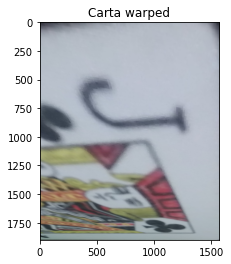

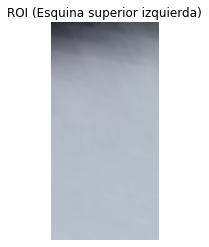

Contornos totales: 142 | Filtrados: 28


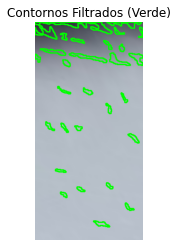

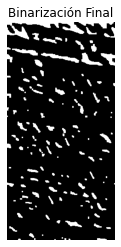

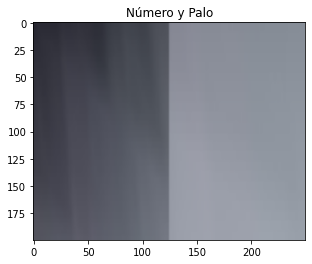

Template mathing:


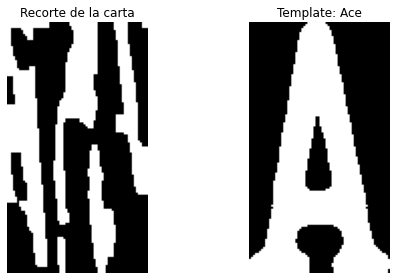

Ace: score = 0.0728


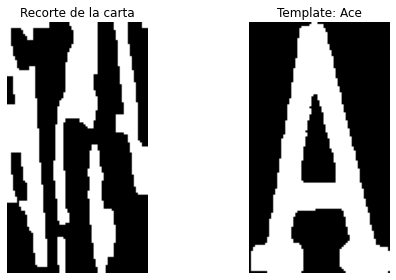

Ace: score = 0.0286


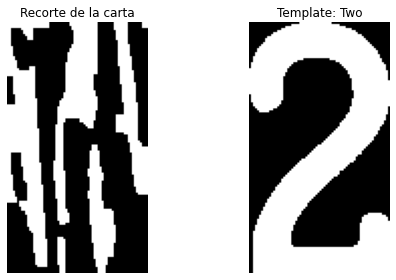

Two: score = -0.1111


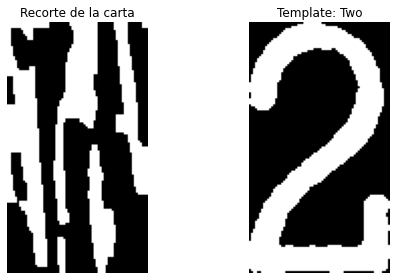

Two: score = -0.0978


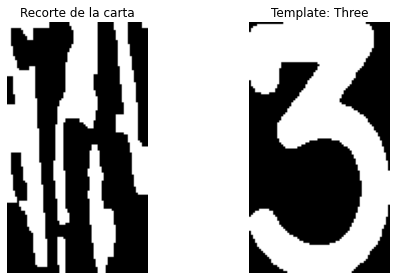

Three: score = 0.0203


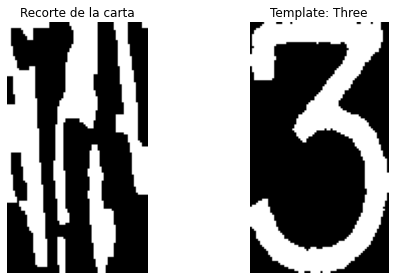

Three: score = 0.0142


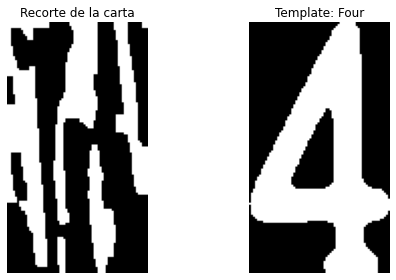

Four: score = 0.0324


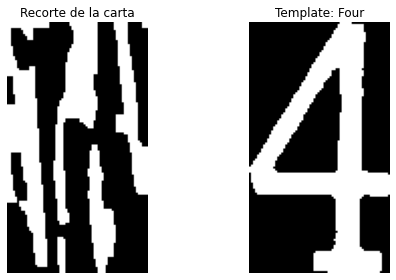

Four: score = 0.0089


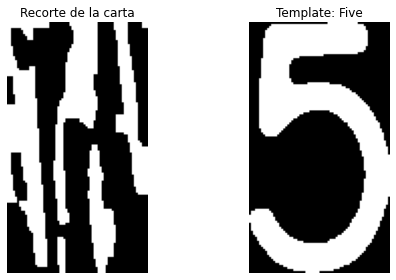

Five: score = 0.0578


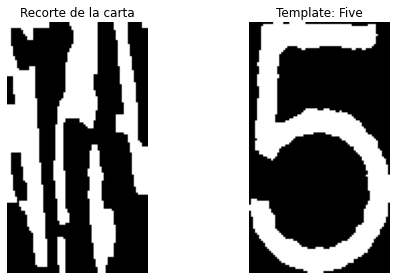

Five: score = 0.0623


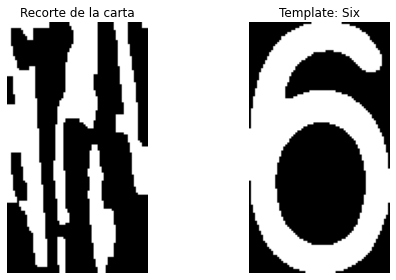

Six: score = 0.1645


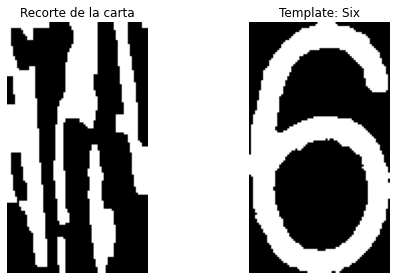

Six: score = 0.0914


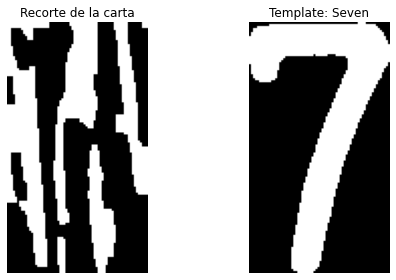

Seven: score = -0.1213


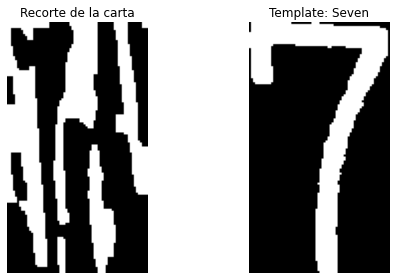

Seven: score = -0.0699


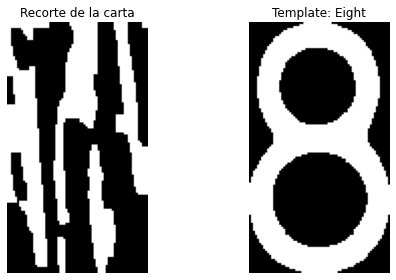

Eight: score = -0.0362


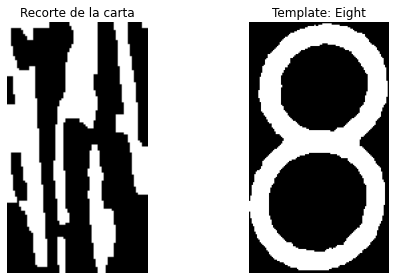

Eight: score = -0.0370


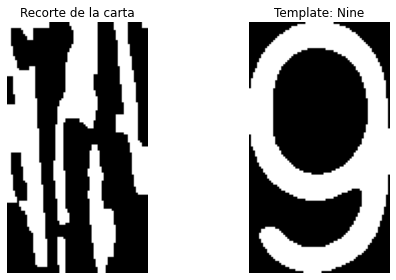

Nine: score = 0.1224


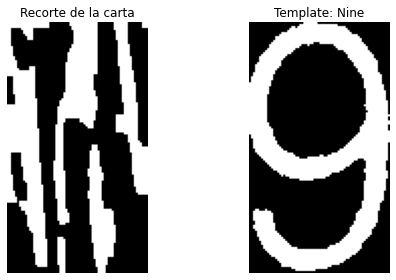

Nine: score = 0.0968


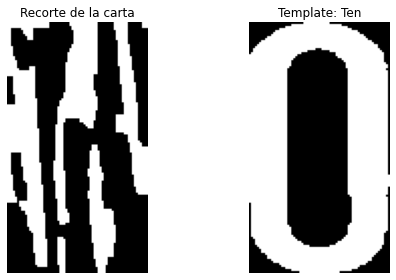

Ten: score = 0.0528


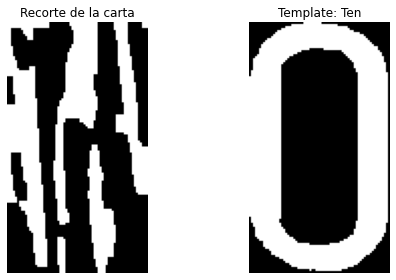

Ten: score = 0.1405


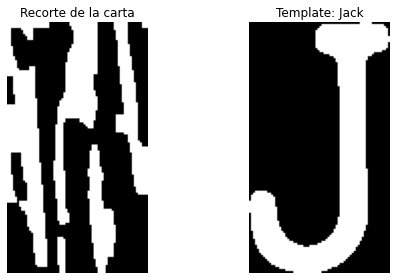

Jack: score = -0.0741


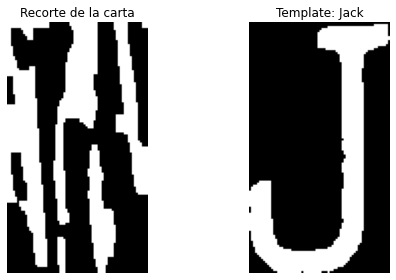

Jack: score = -0.1307


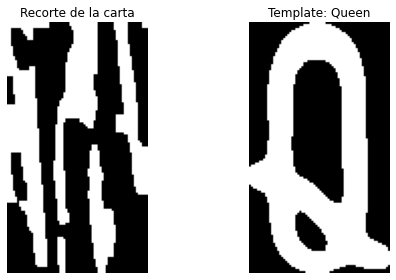

Queen: score = -0.0883


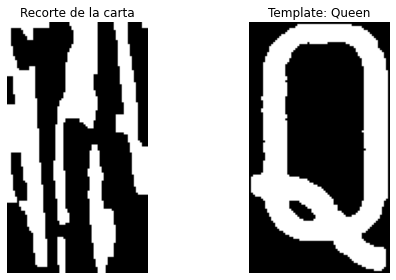

Queen: score = 0.1088


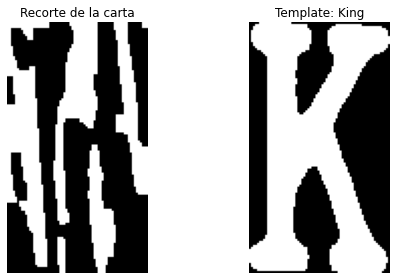

King: score = 0.0384


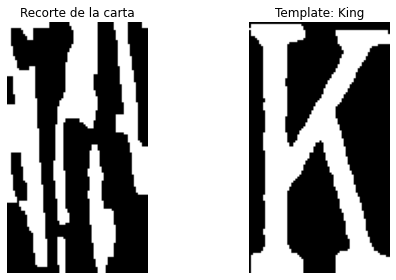

King: score = 0.0686


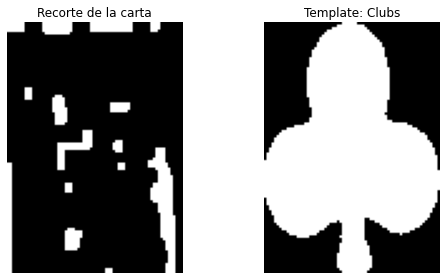

Clubs: score = -0.0109


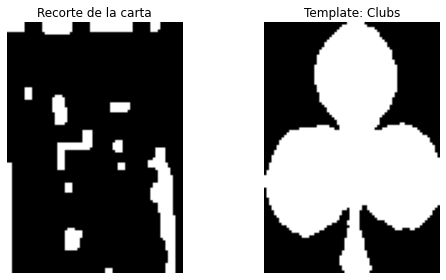

Clubs: score = -0.0318


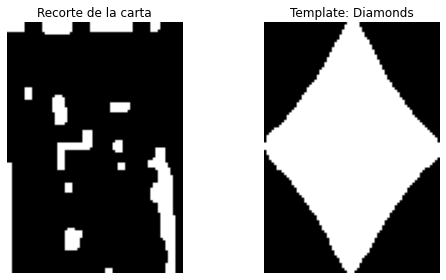

Diamonds: score = -0.0769


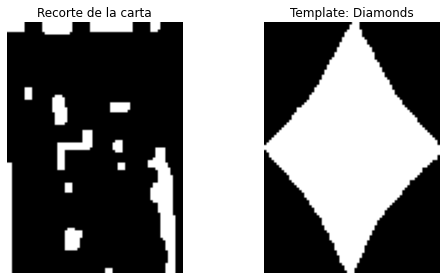

Diamonds: score = -0.0644


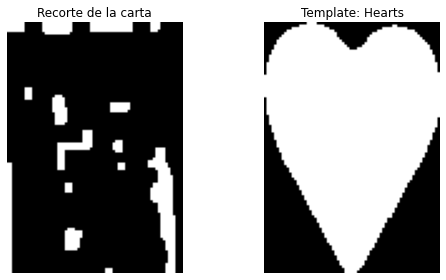

Hearts: score = -0.1759


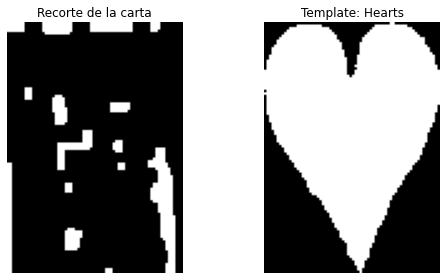

Hearts: score = -0.1615


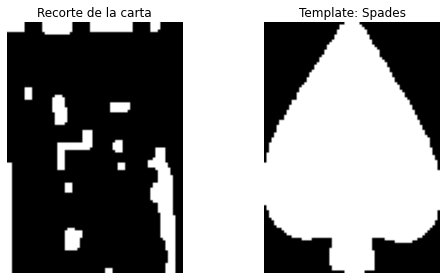

Spades: score = -0.0009


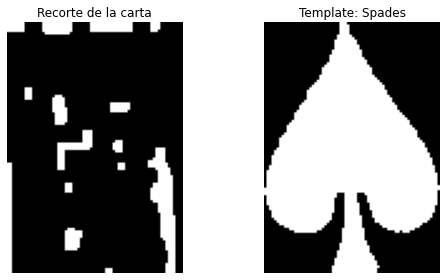

Spades: score = 0.0024
🃏 Carta 3: Six de Spades


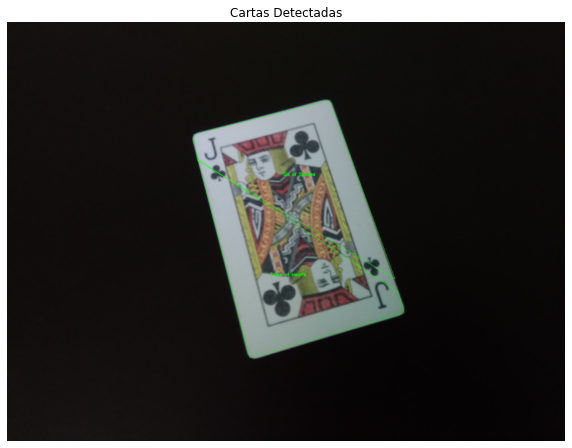

[('Three', 'Hearts'), ('Six', 'Spades')]

In [25]:
main("Fotos/Imagenes/JC0.jpg", debug=True)

## Pruebas de algunas imaganes de todas las cartas

In [28]:
import os
import re
import cv2
import numpy as np

suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

def extraer_datos(nombre):
    match = re.match(r"(\w+)([A-Z])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None

succession = []

# Generar combinaciones: cada carta en 2 posiciones
for number_name, number_symbol in numbers.items():
    for suit_name, suit_symbol in suits.items():
        for i in range(2):
            filename = f"{number_symbol}{suit_symbol}{i}.jpg"
            ruta_completa = os.path.join("Fotos", "Imagenes", filename)

            if not os.path.exists(ruta_completa):
                print(f"⚠️ Archivo no encontrado: {ruta_completa}")
                continue

            print("Archivo:", filename)
            print("-" * 100)

            resultados = main(ruta_completa, debug=False, draw_predictions=False, show_result=False)

            number_pred, suit_pred = extraer_datos(filename)
            expected_symbol = number_symbol + suit_symbol

            if not resultados:
                print("❌ No se detectaron cartas")
                succession.append(False)
            else:
                match_encontrado = False
                for number, suit in resultados:
                    if numbers.get(number) == number_symbol and suits.get(suit) == suit_symbol:
                        print(f"✅ Acierto: {number} of {suit}")
                        succession.append(True)
                        match_encontrado = True
                        break

                if not match_encontrado:
                    print(f"❌ Fallo: ninguna coincidencia para {expected_symbol}")
                    succession.append(False)

            print("=" * 100)

# Calcular totales
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

# Calcular porcentajes
porcentaje_aciertos = (aciertos / total) * 100
porcentaje_fallos = (fallos / total) * 100

print(f"\nResumen final:")
print(f"Aciertos: {aciertos} / {total} → {porcentaje_aciertos:.2f}%")
print(f"Fallos: {fallos} / {total} → {porcentaje_fallos:.2f}%")


Archivo: AC0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Clubs
Archivo: AC1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Clubs
Archivo: AD0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Diamonds
Archivo: AD1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Diamonds
Archivo: AH0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Hearts
Archivo: AH1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo: ninguna coincidencia para AH
Archivo: AS0.jpg
----------------------------------------------------------------------------------------------------
❌ No se d

❌ Fallo: ninguna coincidencia para 5C
Archivo: 5D0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Five of Diamonds
Archivo: 5D1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Five of Diamonds
Archivo: 5H0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo: ninguna coincidencia para 5H
Archivo: 5H1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo: ninguna coincidencia para 5H
Archivo: 5S0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Five of Spades
Archivo: 5S1.jpg
----------------------------------------------------------------------------------------------------
❌ No se detectaron cartas
Archivo: 6C0.jpg
-----------------------------------------------------

✅ Acierto: Nine of Diamonds
Archivo: 9H0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Nine of Hearts
Archivo: 9H1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo: ninguna coincidencia para 9H
Archivo: 9S0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Nine of Spades
Archivo: 9S1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo: ninguna coincidencia para 9S
Archivo: 10C0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ten of Clubs
Archivo: 10C1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ten of Clubs
Archivo: 10D0.jpg
--------------------------------------------------------------------

✅ Acierto: King of Hearts
Archivo: KH1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: King of Hearts
Archivo: KS0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: King of Spades
Archivo: KS1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: King of Spades

Resumen final:
Aciertos: 74 / 104 → 71.15%
Fallos: 30 / 104 → 28.85%


## Prueba de todas las cartas

In [29]:
import os
import re
from tqdm import tqdm  # ✅ Progreso visual
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Diccionarios de conversión
suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

reverse_suits = {v: k for k, v in suits.items()}
reverse_numbers = {v: k for k, v in numbers.items()}

def extraer_datos(nombre):
    match = re.match(r"([A2-9]|10|J|Q|K|A)([CDHS])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None

succession = []

carpeta = os.path.join("Fotos", "Imagenes")
archivos = [f for f in os.listdir(carpeta) if f.lower().endswith(".jpg")]

for filename in tqdm(archivos, desc="Procesando imágenes"):
    ruta_completa = os.path.join(carpeta, filename)

    resultados = main(ruta_completa, debug=False, draw_predictions=False, show_result=False)

    # Asumimos que hay al menos una carta detectada
    if not resultados:
        succession.append(False)
        continue

    number, suit = resultados[0]  # ✅ Consideramos solo la primera carta detectada

    number_prediction, suit_prediction = extraer_datos(filename)

    if suit is None or number is None:
        succession.append(False)
    else:
        try:
            match_number = numbers[number]
            match_suit = suits[suit]

            if match_number == number_prediction and match_suit == suit_prediction:
                succession.append(True)
            else:
                succession.append(False)
        except KeyError:
            succession.append(False)

# === RESUMEN FINAL ===
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

porcentaje_aciertos = (aciertos / total) * 100 if total > 0 else 0
porcentaje_fallos = (fallos / total) * 100 if total > 0 else 0

print(f"\nResumen final:")
print(f"Total imágenes: {total}")
print(f"Aciertos: {aciertos} ({porcentaje_aciertos:.2f}%)")
print(f"Fallos: {fallos} ({porcentaje_fallos:.2f}%)")


Procesando imágenes: 100%|█████████████████████████████████████████████████████████| 2706/2706 [13:02<00:00,  3.46it/s]


Resumen final:
Total imágenes: 2706
Aciertos: 1199 (44.31%)
Fallos: 1507 (55.69%)


### 7. Detección de cartas en tiempo real

Esta función activa la cámara web del dispositivo y ejecuta en tiempo real el proceso de detección de cartas, mostrando el resultado en una ventana hasta que se presione la tecla `'q'`.


¿Qué hace paso a paso?

1. **Inicia la cámara:**
   - Usa `cv2.VideoCapture(0)` para acceder a la cámara por defecto del sistema.
   - Si no se puede acceder, se muestra un mensaje de error.

2. **Bucle principal:**
   - Captura frame por frame desde la cámara.
   - Cada frame se procesa para detectar cartas, siguiendo el mismo flujo que ya hemos implementado.

3. **Procesamiento del frame:**
   - Se preprocesa la imagen (`preprocess_image`) para resaltar los bordes.
   - Se detectan los contornos de posibles cartas (`find_card_contours`).
   - Se cargan las plantillas de números y símbolos (`load_templates`).

4. **Por cada contorno de carta detectado:**
   - Se extrae y corrige la carta (`warp_card` + `correct_card_orientation`).
   - Se valida la proporción de la carta (`is_valid_card_proportion`).
   - Se extraen las regiones del número y símbolo (`extract_number_suit_region`).
   - Se realiza el reconocimiento mediante plantillas (`match_template`).
   - Si todo es exitoso, se guarda la carta detectada.

5. **Visualización:**
   - Se dibujan los contornos y etiquetas (`número de carta` + `símbolo`) directamente sobre la imagen original usando `cv2.putText()` y `cv2.drawContours()`.

6. **Finalización:**
   - El bucle continúa hasta que el usuario presione la tecla `'q'`.
   - Se liberan los recursos de la cámara y se cierran las ventanas de OpenCV.


In [26]:
import cv2
import time

def run_realtime(debug=False, draw_predictions=True):
    cap = cv2.VideoCapture(0)  # Usa la cámara por defecto

    if not cap.isOpened():
        print("❌ No se pudo acceder a la cámara.")
        return

    print("🎥 Cámara iniciada. Presiona 'q' para salir.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ No se pudo leer el frame.")
            break

        image = frame.copy()
        original = image.copy()

        edges = preprocess_image(image)
        card_contours = find_card_contours(edges)

        number_templates, suit_templates = load_templates()
        detected_cards = []

        for i, contour in enumerate(card_contours):
            warped = warp_card(image, contour)
            if warped is None:
                continue

            warped = correct_card_orientation(warped, debug)
            if warped is None or not is_valid_card_proportion(warped, debug=debug):
                continue

            number_region, suit_region = extract_number_suit_region(warped, debug=debug)
            if number_region is not None and suit_region is not None:
                number = match_template(number_region, number_templates, debug=debug)
                suit = match_template(suit_region, suit_templates, debug=debug)
                detected_cards.append((contour, number, suit))

        if draw_predictions:
            for contour, number, suit in detected_cards:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = contour[0][0]

                label = f"{number} of {suit}"
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                text_x = cx - text_width // 2
                text_y = cy + text_height // 2

                cv2.putText(original, label, (text_x, text_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3, cv2.LINE_AA)
                cv2.drawContours(original, [contour], -1, (0, 255, 0), 2)

        # Mostrar resultado en tiempo real
        cv2.imshow("Cartas Detectadas (Tiempo Real)", original)

        # Presionar 'q' para salir
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [30]:
run_realtime(debug=False)


🎥 Cámara iniciada. Presiona 'q' para salir.
